# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [268]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")


In [269]:
# Import the libraries you will be using for analysis
import os
import pandas as pd # Pandas
import numpy as np #numpy
import matplotlib.pyplot as plt #for charts
import seaborn as sns #for charts
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
%matplotlib inline
pd.set_option("display.max_columns", 30) #restriction
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe


In [270]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [271]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [272]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [273]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/MyDrive/12datasets')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        monthly_data = pd.read_parquet(file_path)



        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        monthly_sample_data = pd.DataFrame()
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        monthly_data['tpep_pickup_datetime'] = pd.to_datetime(monthly_data['tpep_pickup_datetime'])
        monthly_data['date'] = monthly_data['tpep_pickup_datetime'].dt.date
        monthly_data['hour'] = monthly_data['tpep_pickup_datetime'].dt.hour

            # Iterate through each hour of the selected date
        for date in monthly_data['date'].unique():
          df_date = monthly_data[monthly_data['date'] == date]
          for hour in range(24):
            df_hour = df_date[df_date['hour'] == hour]

                # Sample 7% of the hourly data randomly
            if not df_hour.empty: #this is to check if hourly df is not empty
              monthly_sample_data = df_hour.sample(frac = 0.007, random_state = 42)

                # add data of this hour to the dataframe
              sampled_data = pd.concat([sampled_data, monthly_sample_data], ignore_index=True)

        # Concatenate the sampled data of all the dates to a single dataframe

        df = pd.concat([df, sampled_data],ignore_index=True) # we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print(f"Shape of the final sampled dataframe: {df.shape}") # to keep monitoring on ther shape of te df, so I can configure the percentage for sampling to get to around 250000 records

Shape of the final sampled dataframe: (268150, 22)


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [274]:
# Store the df in csv/parquet
df.to_csv('/content/drive/MyDrive/EDA_Assignment/12monthsampledata/Combinedfile.csv')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [275]:
# Load the new data file

df = pd.read_csv('/content/drive/MyDrive/EDA_Assignment/12monthsampledata/Combinedfile.csv')

In [276]:
df.head()

Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0           0         2  2023-01-01 00:10:30   2023-01-01 00:11:49   
1           1         2  2023-01-01 00:49:02   2023-01-01 00:55:15   
2           2         1  2023-01-01 00:47:17   2023-01-01 01:07:01   
3           3         2  2023-01-01 00:06:02   2023-01-01 00:31:38   
4           4         2  2023-01-01 00:02:19   2023-01-01 00:30:49   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0              1.0           0.49         1.0                  N   
1              1.0           0.75         1.0                  N   
2              2.0           2.90         1.0                  N   
3              1.0           2.50         1.0                  N   
4              1.0          20.37         2.0                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           239           238             1          4.4    1.0      0.5   
1            45           148             2          7.9    1.0      0.5   
2           142           170             1         19.1    3.5      0.5   
3            43           161             1         24.0    1.0      0.5   
4           132           140             1         70.0    0.0      0.5   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0        1.88          0.00                    1.0         11.28   
1        0.00          0.00                    1.0         12.90   
2        4.80          0.00                    1.0         28.90   
3        7.25          0.00                    1.0         36.25   
4       12.00          6.55                    1.0         92.55   

   congestion_surcharge  airport_fee        date  hour  Airport_fee  
0                   2.5          0.0  2023-01-01     0          NaN  
1                   2.5          0.0  2023-01-01     0          NaN  
2                   2.5          0.0  2023-01-01     0          NaN  
3                   2.5          0.0  2023-01-01     0          NaN  
4                   2.5          0.0  2023-01-01     0          NaN

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268150 entries, 0 to 268149
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             268150 non-null  int64  
 1   VendorID               268150 non-null  int64  
 2   tpep_pickup_datetime   268150 non-null  object 
 3   tpep_dropoff_datetime  268150 non-null  object 
 4   passenger_count        259263 non-null  float64
 5   trip_distance          268150 non-null  float64
 6   RatecodeID             259263 non-null  float64
 7   store_and_fwd_flag     259263 non-null  object 
 8   PULocationID           268150 non-null  int64  
 9   DOLocationID           268150 non-null  int64  
 10  payment_type           268150 non-null  int64  
 11  fare_amount            268150 non-null  float64
 12  extra                  268150 non-null  float64
 13  mta_tax                268150 non-null  float64
 14  tip_amount             268150 non-nu

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [278]:
# Fix the index and drop any columns that are not needed
#resetting index
df.reset_index(drop=True)

Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                0         2  2023-01-01 00:10:30   2023-01-01 00:11:49   
1                1         2  2023-01-01 00:49:02   2023-01-01 00:55:15   
2                2         1  2023-01-01 00:47:17   2023-01-01 01:07:01   
3                3         2  2023-01-01 00:06:02   2023-01-01 00:31:38   
4                4         2  2023-01-01 00:02:19   2023-01-01 00:30:49   
...            ...       ...                  ...                   ...   
268145      268145         2  2023-12-31 23:15:09   2023-12-31 23:20:56   
268146      268146         2  2023-12-31 23:02:45   2023-12-31 23:18:21   
268147      268147         2  2023-12-31 23:31:33   2023-12-31 23:52:27   
268148      268148         2  2023-12-31 23:21:51   2023-12-31 23:28:58   
268149      268149         2  2023-12-31 23:38:22   2023-12-31 23:59:53   

        passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                   1.0           0.49         1.0                  N   
1                   1.0           0.75         1.0                  N   
2                   2.0           2.90         1.0                  N   
3                   1.0           2.50         1.0                  N   
4                   1.0          20.37         2.0                  N   
...                 ...            ...         ...                ...   
268145              NaN           0.84         NaN                NaN   
268146              1.0           2.44         1.0                  N   
268147              1.0           4.79         1.0                  N   
268148              2.0           1.83         1.0                  N   
268149              NaN           8.32         NaN                NaN   

        PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0                239           238             1         4.40    1.0      0.5   
1                 45           148             2         7.90    1.0      0.5   
2                142           170             1        19.10    3.5      0.5   
3                 43           161             1        24.00    1.0      0.5   
4                132           140             1        70.00    0.0      0.5   
...              ...           ...           ...          ...    ...      ...   
268145            42            41             0         8.58    0.0      0.5   
268146            68           211             1        15.60    1.0      0.5   
268147            90            25             1        24.70    1.0      0.5   
268148           148           137             1        10.00    1.0      0.5   
268149           170           116             0        35.40    0.0      0.5   

        tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0             1.88          0.00                    1.0         11.28   
1             0.00          0.00                    1.0         12.90   
2             4.80          0.00                    1.0         28.90   
3             7.25          0.00                    1.0         36.25   
4            12.00          6.55                    1.0         92.55   
...            ...           ...                    ...           ...   
268145        0.00          0.00                    1.0         10.08   
268146        4.12          0.00                    1.0         24.72   
268147        5.94          0.00                    1.0         35.64   
268148        3.00          0.00                    1.0         18.00   
268149        0.00          0.00                    1.0         39.40   

        congestion_surcharge  airport_fee        date  hour  Airport_fee  
0                        2.5          0.0  2023-01-01     0          NaN  
1                        2.5          0.0  2023-01-01     0          NaN  
2                        2.5          0.0  2023-01-01     0          NaN  
3                        2.5          0.0  2023-01-01     0          NaN  
4    

In [279]:
df.columns.tolist()

['Unnamed: 0',
 'VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'date',
 'hour',
 'Airport_fee']

In [280]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [281]:
df.shape

(268150, 22)

In [282]:
df.drop('date',axis=1,inplace=True) #droping date and hour columns as well they were created during sampling.
df.drop('hour',axis=1,inplace=True)
df.drop('store_and_fwd_flag',axis=1,inplace=True)

In [283]:
df.shape

(268150, 19)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [284]:
# Combine the two airport fee columns
df['Airport_fee'].unique()


array([  nan,  0.  ,  1.25, -1.25,  1.75, -1.75])

In [285]:
df['airport_fee'].unique()

array([ 0.  ,   nan,  1.25, -1.25])

In [286]:
df['Airport_fee_new'] = df[['Airport_fee', 'airport_fee']].sum(axis=1, skipna=True)

In [287]:
df['Airport_fee_new'].unique()

array([ 0.  ,  1.25, -1.25,  1.75, -1.75])

In [288]:
df.drop('Airport_fee',axis=1,inplace=True)
df.drop('airport_fee',axis=1,inplace=True)
# dropping earlier two columns "Airport_fee' and 'airport_fee", as I have created a new column name

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268150 entries, 0 to 268149
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               268150 non-null  int64  
 1   tpep_pickup_datetime   268150 non-null  object 
 2   tpep_dropoff_datetime  268150 non-null  object 
 3   passenger_count        259263 non-null  float64
 4   trip_distance          268150 non-null  float64
 5   RatecodeID             259263 non-null  float64
 6   PULocationID           268150 non-null  int64  
 7   DOLocationID           268150 non-null  int64  
 8   payment_type           268150 non-null  int64  
 9   fare_amount            268150 non-null  float64
 10  extra                  268150 non-null  float64
 11  mta_tax                268150 non-null  float64
 12  tip_amount             268150 non-null  float64
 13  tolls_amount           268150 non-null  float64
 14  improvement_surcharge  268150 non-nu

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [290]:
# check where values of fare amount are negative

print(df[df['fare_amount'] < 0]['fare_amount'].unique())

[-2.300e+01 -1.070e+01 -3.000e+00 -1.490e+01 -1.630e+01 -1.014e+02
 -1.910e+01 -8.560e+01 -1.560e+01 -3.700e+00 -1.210e+01 -5.100e+00
 -7.200e+00 -2.890e+01 -8.600e+00 -2.960e+01 -4.400e+00 -7.900e+00
 -1.000e+01 -5.200e+01 -1.420e+01 -2.400e+01 -1.700e+01 -2.120e+01
 -1.350e+01 -2.050e+01 -2.610e+01 -4.710e+01 -3.940e+01 -7.000e+01
 -5.800e+00 -1.280e+01 -6.500e+00 -9.300e+00 -2.330e+01 -2.750e+01
 -1.770e+01 -2.540e+01 -4.500e+01 -2.680e+01 -1.980e+01 -5.500e+01
 -9.580e+01 -1.140e+01 -4.220e+01 -1.500e+01 -2.820e+01 -8.400e+01
 -3.450e+01 -3.870e+01 -2.190e+01 -2.260e+01 -1.050e+01 -2.766e+01
 -5.830e+01 -3.310e+01 -5.760e+01 -4.430e+01 -3.380e+01 -1.840e+01
 -3.800e+01 -3.000e+02 -3.100e+01 -1.200e+02 -3.170e+01 -6.000e+01
 -3.030e+01 -6.180e+01 -5.130e+01 -5.410e+01 -4.080e+01 -4.150e+01
 -3.590e+01 -5.480e+01 -6.110e+01 -5.970e+01 -3.520e+01 -6.600e+01
 -1.630e+02 -5.550e+01 -3.660e+01 -6.390e+01 -9.190e+01 -5.690e+01
 -4.360e+01 -4.570e+01 -4.780e+01 -7.020e+01 -6.530e+01 -3.240

Did you notice something different in the `RatecodeID` column for above records?

In [291]:
# Analyse RatecodeID for the negative fare amounts

negative_fares = df[df['fare_amount'] < 0] # filtering for negative fare amounts

# Step 2: Count by RatecodeID
ratecode_summary = negative_fares['RatecodeID'].value_counts().sort_index() #getting count by RateCodeID

# Step 3: View RatecodeID vs fare statistics (optional)
ratecode_fare_stats = negative_fares.groupby('RatecodeID')['fare_amount'].describe()



In [292]:
#  Display results
print("Count of Negative Fares by RatecodeID:")
print(ratecode_summary)

print("Summary Statistics of Negative Fares by RatecodeID:")
print(ratecode_fare_stats)

Count of Negative Fares by RatecodeID:
RatecodeID
1.0    2353
2.0     193
3.0      27
4.0      12
5.0      40
Name: count, dtype: int64
Summary Statistics of Negative Fares by RatecodeID:
             count        mean         std    min       25%     50%     75%  \
RatecodeID                                                                    
1.0         2353.0  -14.968041   15.142616 -222.8  -17.7000  -10.00  -5.800   
2.0          193.0  -70.000000    0.000000  -70.0  -70.0000  -70.00 -70.000   
3.0           27.0  -41.822222   31.651204 -101.4  -54.1500  -23.00 -23.000   
4.0           12.0 -175.900000  171.219381 -525.2 -188.8500 -102.75 -62.325   
5.0           40.0  -67.940250   63.000019 -300.0  -85.3875  -60.00 -16.500   

             max  
RatecodeID        
1.0         -0.7  
2.0        -70.0  
3.0        -23.0  
4.0        -42.9  
5.0         -3.0  


In [293]:
# Find which columns have negative values
colums_with_numbers = df.select_dtypes(include='number') #this is to find the columns which has numeric values

negative_values = (colums_with_numbers < 0).any() #this is to check the negative values in the columns identified above


negative_columns = negative_values[negative_values].index.tolist() #this is to identify and filter out the columns that have atleast one negative value

print("Columns with negative values:", negative_columns) #printing the list of columns with atleast one negative value


Columns with negative values: ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee_new']


In [294]:
# fix these negative values

df['improvement_surcharge'].unique()

array([ 1. ,  0.3, -1. ,  0. , -0.3])

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




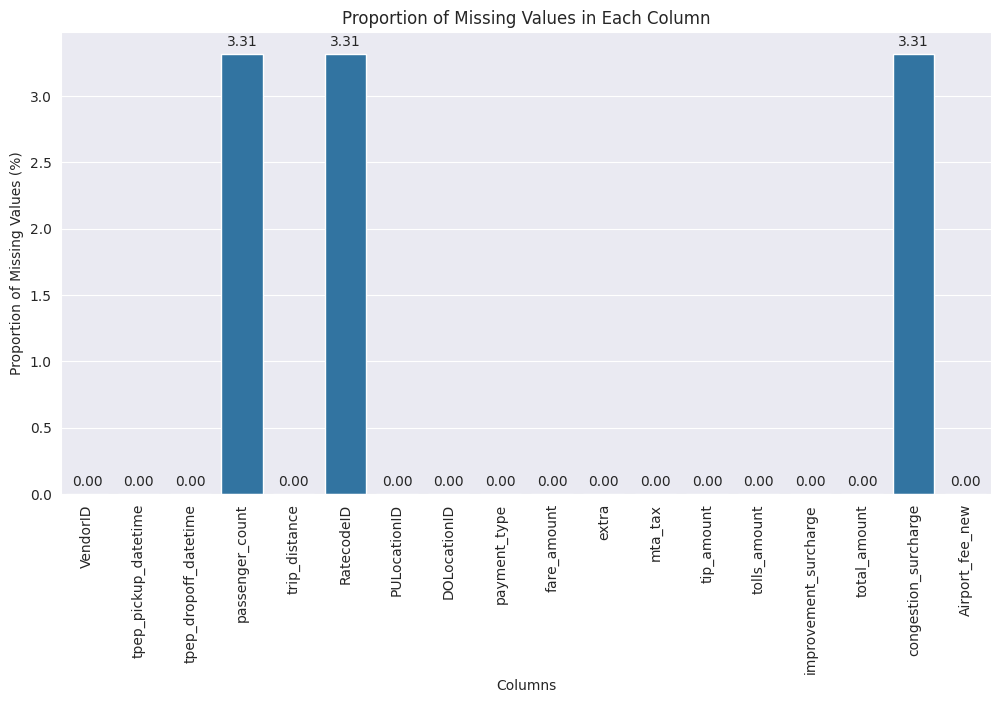

In [295]:
# Find the proportion of missing values in each column
def render_bar_plot(x, y, title, xlabel, ylabel, figsize=(12, 6), show_data_labels=False):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)

    if show_data_labels:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.show()

# Calculate the proportion of missing values in each column
missing_values = df.isna().mean() * 100
render_bar_plot(missing_values.index, missing_values.values, 'Proportion of Missing Values in Each Column', 'Columns',
                'Proportion of Missing Values (%)', show_data_labels=True)


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [296]:
# Display the rows with null values
null_rows = df[df.isnull().any(axis=1)]
null_rows

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5              2  2023-01-01 00:45:00   2023-01-01 01:21:00              NaN   
6              2  2023-01-01 00:56:00   2023-01-01 01:08:45              NaN   
67             2  2023-01-01 01:45:11   2023-01-01 02:00:49              NaN   
70             2  2023-01-01 01:39:32   2023-01-01 01:51:28              NaN   
71             2  2023-01-01 01:26:44   2023-01-01 01:31:09              NaN   
...          ...                  ...                   ...              ...   
268132         2  2023-12-31 23:20:41   2023-12-31 23:53:58              NaN   
268135         2  2023-12-31 23:36:15   2023-12-31 23:50:18              NaN   
268137         2  2023-12-31 23:35:44   2024-01-01 00:02:29              NaN   
268145         2  2023-12-31 23:15:09   2023-12-31 23:20:56              NaN   
268149         2  2023-12-31 23:38:22   2023-12-31 23:59:53              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
5                6.00         NaN           234           225             0   
6                2.89         NaN           181            17             0   
67               6.27         NaN           209           140             0   
70               3.53         NaN            41           141             0   
71               0.54         NaN           151           151             0   
...               ...         ...           ...           ...           ...   
268132          15.70         NaN           218           145             0   
268135           3.05         NaN           141           238             0   
268137          16.38         NaN            81            50             0   
268145           0.84         NaN            42            41             0   
268149           8.32         NaN           170           116             0   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
5             38.77    0.0      0.5        0.00           0.0   
6             17.17    0.0      0.5        3.73           0.0   
67            29.31    0.0      0.5        6.66           0.0   
70            20.92    0.0      0.5        4.84           0.0   
71            12.80    0.0      0.5        2.86           0.0   
...             ...    ...      ...         ...           ...   
268132        44.44    0.0      0.5        0.00           0.0   
268135        15.95    0.0      0.5        0.00           0.0   
268137        53.75    0.0      0.5        0.00           0.0   
268145         8.58    0.0      0.5        0.00           0.0   
268149        35.40    0.0      0.5        0.00           0.0   

        improvement_surcharge  total_amount  congestion_surcharge  \
5                         1.0         42.77                   NaN   
6                         1.0         22.40                   NaN   
67                        1.0         39.97                   NaN   
70                        0.3         29.06                   NaN   
71                        1.0         17.16                   NaN   
...                       ...           ...                   ...   
268132                    1.0         45.94                   NaN   
268135                    1.0         19.95                   NaN   
268137                    1.0         57.75                   NaN   
268145                    1.0         10.08                   NaN   
268149                    1.0         39.40                   NaN   

        Airport_fee_new  
5                   0.0  
6                   0.0  
67                  0.0  
70                  0.0  
71                  0.0  
...                 ...  
268132              0.0  
268135              0.0  
268137              0.0  
268145              0.0  
268149              0.0  

[8887 rows x 18 columns]

In [297]:
# Display the rows with null values
null_rows = df[df.isnull().any(axis=1)]
null_rows
# Impute NaN values in 'passenger_count'
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)


In [298]:
df['passenger_count'].isna().value_counts()

passenger_count
False    268150
Name: count, dtype: int64

Did you find zeroes in passenger_count? Handle these.

In [299]:
# Fix zero values in 'passenger_count'
df['passenger_count'] = df['passenger_count'].replace(0, df['passenger_count'].median())

In [300]:
df['passenger_count'].value_counts()

passenger_count
1.0    207742
2.0     39572
3.0      9674
4.0      5562
5.0      3367
6.0      2230
8.0         3
Name: count, dtype: int64

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [301]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'].isna().value_counts()

RatecodeID
False    259263
True       8887
Name: count, dtype: int64

In [302]:
df['RatecodeID'].value_counts()

RatecodeID
1.0     244540
2.0      10361
5.0       1507
99.0      1466
3.0        869
4.0        518
6.0          2
Name: count, dtype: int64

In [303]:
# replace null with 1
df['RatecodeID'].fillna(1, inplace=True)
# replace 99.0 with 1
df['RatecodeID'] = df['RatecodeID'].replace(99.0, 1)
df["RatecodeID"] = df["RatecodeID"].astype(int)
df['RatecodeID'].value_counts()

RatecodeID
1    254893
2     10361
5      1507
3       869
4       518
6         2
Name: count, dtype: int64

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [304]:
# handle null values in congestion_surcharge

df['congestion_surcharge'].value_counts()


congestion_surcharge
 2.5    236926
 0.0     20220
-2.5      2117
Name: count, dtype: int64

In [305]:
# Impute the missing values in 'congestion_surcharge' with the median value
df["congestion_surcharge"].fillna(df["congestion_surcharge"].median(), inplace=True)

In [306]:
print(f"Missing value% 'congestion_surcharge': {df['congestion_surcharge'].isna().mean() * 100}%")
print(f"Missing value% 'passenger_count': {(df['passenger_count'] == 0).sum() / len(df) * 100}%")

Missing value% 'congestion_surcharge': 0.0%
Missing value% 'passenger_count': 0.0%


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [307]:
# Handle any remaining missing values
#--> below bar plot shows all missing value handeled.


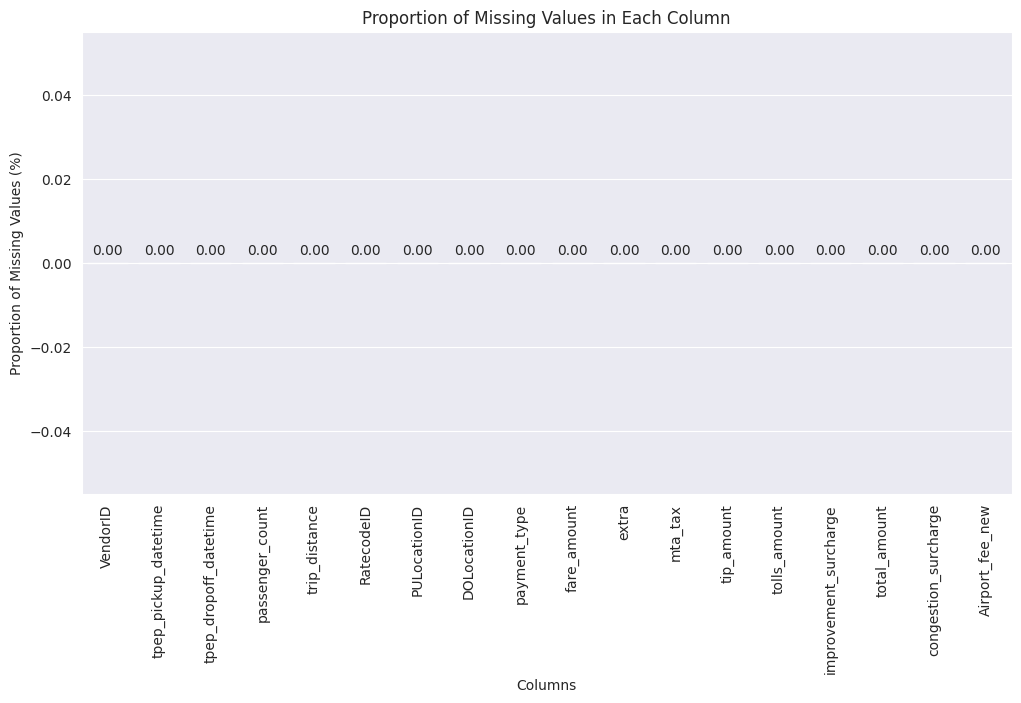

In [308]:
# Find the proportion of missing values in each column
def render_bar_plot(x, y, title, xlabel, ylabel, figsize=(12, 6), show_data_labels=False):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)

    if show_data_labels:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.show()

# Find the proportion of missing values in each column

# Calculate the proportion of missing values in each column
missing_values = df.isna().mean() * 100
render_bar_plot(missing_values.index, missing_values.values, 'Proportion of Missing Values in Each Column', 'Columns', 'Proportion of Missing Values (%)', show_data_labels=True)


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [309]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns



In [310]:
df['RatecodeID'] = df['RatecodeID'].astype('Int64')
df['passenger_count'] = df['passenger_count'].astype('Int64')

df['passenger_count']

0         1
1         1
2         2
3         1
4         1
         ..
268145    1
268146    1
268147    1
268148    2
268149    1
Name: passenger_count, Length: 268150, dtype: Int64

In [311]:
df['passenger_count'].value_counts()

passenger_count
1    207742
2     39572
3      9674
4      5562
5      3367
6      2230
8         3
Name: count, dtype: Int64

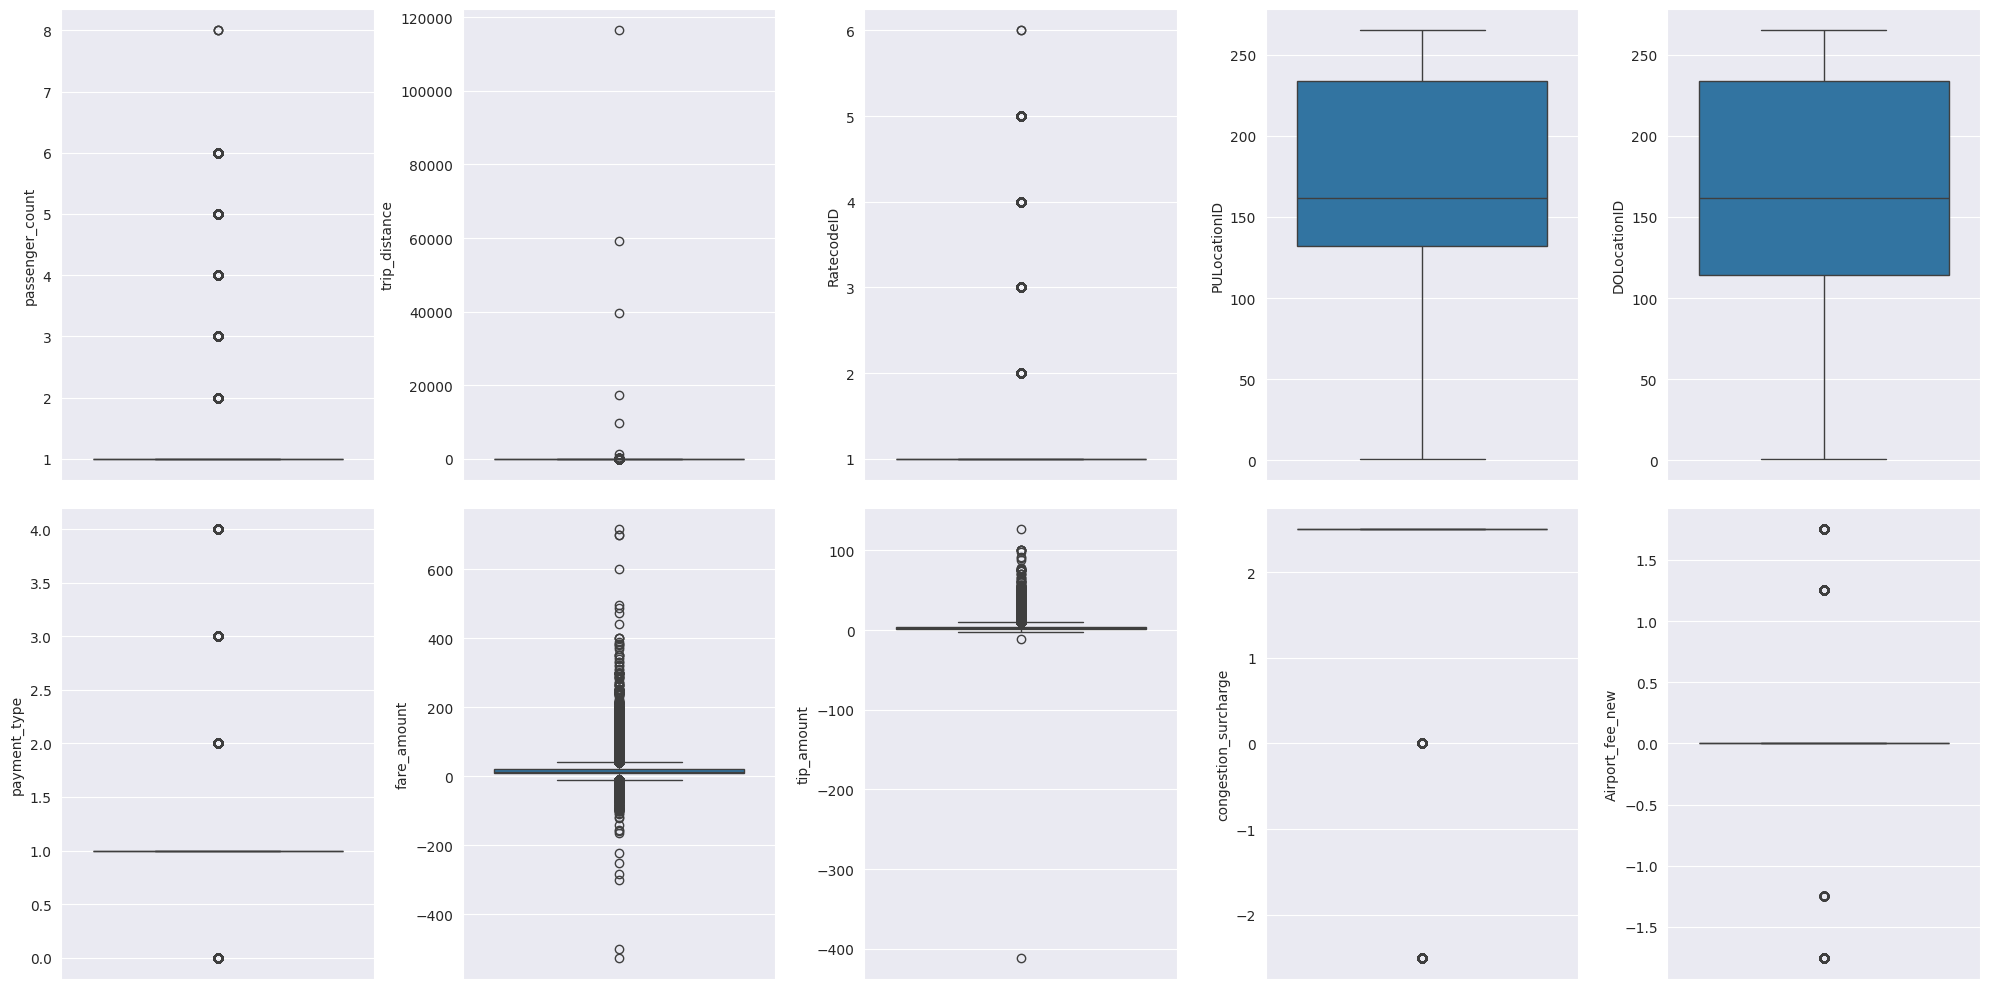

In [312]:
numerical_columns = ['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
                     'payment_type', 'fare_amount', 'tip_amount', 'congestion_surcharge', 'Airport_fee_new']
numerical_columns_len = len(numerical_columns)
rows = int(len(numerical_columns) / 2)
fig, axs = plt.subplots(ncols=int(len(numerical_columns) / 2), nrows=2, figsize=(20, 2 * rows))

axs = axs.flatten() if numerical_columns_len > 1 else [axs]  # Ensure axs is iterable
for index, col in enumerate(numerical_columns):
    sns.boxplot(y=col, data=df, ax=axs[index])

plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [313]:
df[df['passenger_count'] > 6]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
76816          2  2023-04-19 05:41:02   2023-04-19 05:41:09                8   
115907         2  2023-06-04 03:00:41   2023-06-04 03:00:43                8   
226145         2  2023-11-07 06:44:39   2023-11-07 07:29:03                8   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
76816            0.00           5           231           231             1   
115907           0.00           5           164           164             1   
226145          16.94           5           100           132             2   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
76816          82.0    0.0      0.5        17.2          0.00   
115907         80.0    0.0      0.5         5.0          0.00   
226145         85.0    0.0      0.0         0.0          6.94   

        improvement_surcharge  total_amount  congestion_surcharge  \
76816                     1.0        103.20                   2.5   
115907                    1.0         86.50                   0.0   
226145                    1.0         95.44                   2.5   

        Airport_fee_new  
76816               0.0  
115907              0.0  
226145              0.0

In [314]:
# remove passenger_count > 6
df = df[df['passenger_count'] <= 6]

In [315]:
df[df['passenger_count'] < 6]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0              2  2023-01-01 00:10:30   2023-01-01 00:11:49                1   
1              2  2023-01-01 00:49:02   2023-01-01 00:55:15                1   
2              1  2023-01-01 00:47:17   2023-01-01 01:07:01                2   
3              2  2023-01-01 00:06:02   2023-01-01 00:31:38                1   
4              2  2023-01-01 00:02:19   2023-01-01 00:30:49                1   
...          ...                  ...                   ...              ...   
268145         2  2023-12-31 23:15:09   2023-12-31 23:20:56                1   
268146         2  2023-12-31 23:02:45   2023-12-31 23:18:21                1   
268147         2  2023-12-31 23:31:33   2023-12-31 23:52:27                1   
268148         2  2023-12-31 23:21:51   2023-12-31 23:28:58                2   
268149         2  2023-12-31 23:38:22   2023-12-31 23:59:53                1   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0                0.49           1           239           238             1   
1                0.75           1            45           148             2   
2                2.90           1           142           170             1   
3                2.50           1            43           161             1   
4               20.37           2           132           140             1   
...               ...         ...           ...           ...           ...   
268145           0.84           1            42            41             0   
268146           2.44           1            68           211             1   
268147           4.79           1            90            25             1   
268148           1.83           1           148           137             1   
268149           8.32           1           170           116             0   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0              4.40    1.0      0.5        1.88          0.00   
1              7.90    1.0      0.5        0.00          0.00   
2             19.10    3.5      0.5        4.80          0.00   
3             24.00    1.0      0.5        7.25          0.00   
4             70.00    0.0      0.5       12.00          6.55   
...             ...    ...      ...         ...           ...   
268145         8.58    0.0      0.5        0.00          0.00   
268146        15.60    1.0      0.5        4.12          0.00   
268147        24.70    1.0      0.5        5.94          0.00   
268148        10.00    1.0      0.5        3.00          0.00   
268149        35.40    0.0      0.5        0.00          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
0                         1.0         11.28                   2.5   
1                         1.0         12.90                   2.5   
2                         1.0         28.90                   2.5   
3                         1.0         36.25                   2.5   
4                         1.0         92.55                   2.5   
...                       ...           ...                   ...   
268145                    1.0         10.08                   2.5   
268146                    1.0         24.72                   2.5   
268147                    1.0         35.64                   2.5   
268148                    1.0         18.00                   2.5   
268149                    1.0         39.40                   2.5   

        Airport_fee_new  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
268145              0.0  
268146              0.0  
268147              0.0  
268148              0.0  
268149              0.0  

[265917 rows x 18 columns]

In [396]:
df.describe()

VendorID  passenger_count  trip_distance  RatecodeID  \
count  259195.000000         259195.0  259195.000000    259195.0   
mean        1.739968         1.386612       3.441724    1.075565   
std         0.438653         0.876606       4.585447    0.396653   
min         1.000000              1.0       0.000000         1.0   
25%         1.000000              1.0       1.040000         1.0   
50%         2.000000              1.0       1.770000         1.0   
75%         2.000000              1.0       3.370000         1.0   
max         2.000000              6.0     209.800000         6.0   

        PULocationID   DOLocationID   payment_type    fare_amount  \
count  259195.000000  259195.000000  259195.000000  259188.000000   
mean      165.198522     164.242003       1.227200      19.733013   
std        63.753554      69.756774       0.519471      18.367839   
min         1.000000       1.000000       1.000000       0.010000   
25%       132.000000     114.000000       1.000000       9.300000   
50%       162.000000     162.000000       1.000000      13.500000   
75%       234.000000     234.000000       1.000000      21.900000   
max       265.000000     265.000000       4.000000     715.600000   

               extra        mta_tax     tip_amount   tolls_amount  \
count  259195.000000  259195.000000  259195.000000  259195.000000   
mean        1.608313       0.485404       3.537864       0.583266   
std         1.850950       0.109727       4.127373       2.166964   
min        -7.500000      -0.500000    -411.000000     -42.000000   
25%         0.000000       0.500000       1.000000       0.000000   
50%         1.000000       0.500000       2.800000       0.000000   
75%         2.500000       0.500000       4.410000       0.000000   
max        11.750000       0.800000     126.350000      72.000000   

       improvement_surcharge   total_amount  congestion_surcharge  \
count          259195.000000  259195.000000         259195.000000   
mean                0.979101      28.319636              2.264723   
std                 0.201691      23.706997              0.796767   
min                -1.000000    -505.950000             -2.500000   
25%                 1.000000      15.750000              2.500000   
50%                 1.000000      20.930000              2.500000   
75%                 1.000000      30.600000              2.500000   
max                 1.000000     724.150000              2.500000   

       Airport_fee_new    pickup_hour     pickup_day   pickup_month  
count    259195.000000  259195.000000  259195.000000  259195.000000  
mean          0.138798      14.294770       2.996559       6.515897  
std           0.466515       5.783646       1.928635       3.463800  
min          -1.750000       0.000000       0.000000       1.000000  
25%           0.000000      11.000000       1.000000       4.000000  
50%           0.000000      15.000000       3.000000       6.000000  
75%           0.000000      19.000000       5.000000      10.000000  
max           1.750000      23.000000       6.000000      12.000000

In [317]:
# Remove rows where passenger_count is 0
df[df['passenger_count'] == 0] # 0 record with passenger count 0 hence this is not required.

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee_new]
Index: []

In [398]:
df['passenger_count'].value_counts()

passenger_count
1    198800
2     39566
3      9672
4      5560
5      3367
6      2230
Name: count, dtype: Int64

In [319]:
# Remove entries where payment_type is 0
df['payment_type'].value_counts()



payment_type
1    209042
2     44995
0      8887
4      3510
3      1713
Name: count, dtype: int64

In [320]:
df=df[df['payment_type'] != 0]

In [321]:
df['payment_type'].value_counts()

payment_type
1    209042
2     44995
4      3510
3      1713
Name: count, dtype: int64

In [322]:
# Entries where trip_distance ≈ 0 and fare_amount > 300
print("Total entries where trip_distance ≈ 0 and fare_amount > 300:-",((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300)).sum())
df[((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]

Total entries where trip_distance ≈ 0 and fare_amount > 300:- 9


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
35890          1  2023-02-19 14:10:15   2023-02-19 14:13:37                1   
114977         2  2023-06-02 23:54:48   2023-06-02 23:55:23                4   
141403         2  2023-07-10 00:10:01   2023-07-10 00:10:39                4   
164234         2  2023-08-12 08:48:32   2023-08-12 08:48:48                1   
177692         2  2023-09-02 22:28:12   2023-09-02 22:28:27                1   
182991         2  2023-09-10 01:27:09   2023-09-10 01:27:15                1   
207940         2  2023-10-15 17:49:03   2023-10-15 17:49:05                3   
225087         2  2023-11-05 16:17:38   2023-11-05 16:17:53                1   
266081         2  2023-12-28 14:47:43   2023-12-28 14:47:53                1   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
35890             0.0           5           265           265             1   
114977            0.0           5           265           265             1   
141403            0.0           5           265           265             2   
164234            0.0           5           265           265             1   
177692            0.0           5           132           132             2   
182991            0.0           5           265           265             1   
207940            0.0           5           264           264             1   
225087            0.0           5           265           265             1   
266081            0.0           5           164           164             3   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
35890        320.00    0.0      0.0        0.00           0.0   
114977       495.00    0.0      0.0        0.00           0.0   
141403       700.00    0.0      0.0        0.00           0.0   
164234       382.00    0.0      0.0       20.00           0.0   
177692       340.00    0.0      0.0        0.00           0.0   
182991       330.00    0.0      0.0       66.20           0.0   
207940       350.00    0.0      0.0        0.00           0.0   
225087       322.22    0.0      0.0        0.01           0.0   
266081       700.00    0.0      0.0        0.00           0.0   

        improvement_surcharge  total_amount  congestion_surcharge  \
35890                     1.0        321.00                   0.0   
114977                    1.0        496.00                   0.0   
141403                    1.0        701.00                   0.0   
164234                    1.0        403.00                   0.0   
177692                    1.0        342.75                   0.0   
182991                    1.0        397.20                   0.0   
207940                    1.0        351.00                   0.0   
225087                    1.0        323.23                   0.0   
266081                    1.0        703.50                   2.5   

        Airport_fee_new  
35890              0.00  
114977             0.00  
141403             0.00  
164234             0.00  
177692             1.75  
182991             0.00  
207940             0.00  
225087             0.00  
266081             0.00

In [323]:
 df= df[~((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]

In [324]:
# Entrieswhere trip_distance = 0 & fare_amount =0, but pickup and dropoff locations are different
df=df[~((df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID']))]

In [325]:
# Records with trip_distance greater than 250 miles
df[df['trip_distance'] >250]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
85521          2  2023-04-23 23:23:32   2023-04-23 23:43:40                1   
194489         2  2023-09-28 15:42:16   2023-09-28 16:03:29                2   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
85521         1342.94           1           113           113             1   
194489        9674.28           1           246           230             1   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
85521          23.0    1.0      0.5        0.00           0.0   
194489         18.4    0.0      0.5        4.48           0.0   

        improvement_surcharge  total_amount  congestion_surcharge  \
85521                     1.0         28.00                   2.5   
194489                    1.0         26.88                   2.5   

        Airport_fee_new  
85521               0.0  
194489              0.0

In [326]:
df = df[df['trip_distance'] <= 250]

In [327]:
#Dropping rows where trip_distance == 0 and fare_amount == 0
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] == 0))]

In [328]:
#Assign the most common valid payment_type to these rows:
most_common_payment = df.loc[df['payment_type'] != 0, 'payment_type'].mode()[0]
df['payment_type'].replace(0, most_common_payment, inplace=True)

In [329]:
# Continue with outlier handling



In [330]:
# Do any columns need standardising?
df = df[df['tolls_amount']<100] #Handling high toll amounts


In [331]:
# Find the mode (most common value) of RatecodeID
most_common_ratecode = df.loc[df['RatecodeID'] <= 6, 'RatecodeID'].mode()[0]

# Replace RatecodeID values greater than 6 with the mode
df.loc[df['RatecodeID'] > 6, 'RatecodeID'] = most_common_ratecode

In [332]:
df.describe()

VendorID  passenger_count  trip_distance  RatecodeID  \
count  259195.000000         259195.0  259195.000000    259195.0   
mean        1.739968         1.386612       3.441724    1.075565   
std         0.438653         0.876606       4.585447    0.396653   
min         1.000000              1.0       0.000000         1.0   
25%         1.000000              1.0       1.040000         1.0   
50%         2.000000              1.0       1.770000         1.0   
75%         2.000000              1.0       3.370000         1.0   
max         2.000000              6.0     209.800000         6.0   

        PULocationID   DOLocationID   payment_type    fare_amount  \
count  259195.000000  259195.000000  259195.000000  259195.000000   
mean      165.198522     164.242003       1.227200      19.342882   
std        63.753554      69.756774       0.519471      18.939045   
min         1.000000       1.000000       1.000000    -525.200000   
25%       132.000000     114.000000       1.000000       9.300000   
50%       162.000000     162.000000       1.000000      13.500000   
75%       234.000000     234.000000       1.000000      21.900000   
max       265.000000     265.000000       4.000000     715.600000   

               extra        mta_tax     tip_amount   tolls_amount  \
count  259195.000000  259195.000000  259195.000000  259195.000000   
mean        1.608313       0.485404       3.537864       0.583266   
std         1.850950       0.109727       4.127373       2.166964   
min        -7.500000      -0.500000    -411.000000     -42.000000   
25%         0.000000       0.500000       1.000000       0.000000   
50%         1.000000       0.500000       2.800000       0.000000   
75%         2.500000       0.500000       4.410000       0.000000   
max        11.750000       0.800000     126.350000      72.000000   

       improvement_surcharge   total_amount  congestion_surcharge  \
count          259195.000000  259195.000000         259195.000000   
mean                0.979101      28.319636              2.264723   
std                 0.201691      23.706997              0.796767   
min                -1.000000    -505.950000             -2.500000   
25%                 1.000000      15.750000              2.500000   
50%                 1.000000      20.930000              2.500000   
75%                 1.000000      30.600000              2.500000   
max                 1.000000     724.150000              2.500000   

       Airport_fee_new  
count    259195.000000  
mean          0.138798  
std           0.466515  
min          -1.750000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.750000

In [333]:
#Impute with median ,fare_amount == 0 for trips with trip_distance > 0
# Calculate median fare per mile
median_fare_per_mile = df[df['fare_amount'] > 0].groupby('trip_distance')['fare_amount'].median()

# Apply imputation
df.loc[(df['fare_amount'] <= 0) & (df['trip_distance'] >= 0), 'fare_amount'] = \
    df['trip_distance'].map(median_fare_per_mile)

In [334]:
df[df['fare_amount'] <= 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, Airport_fee_new]
Index: []

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [335]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee_new']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

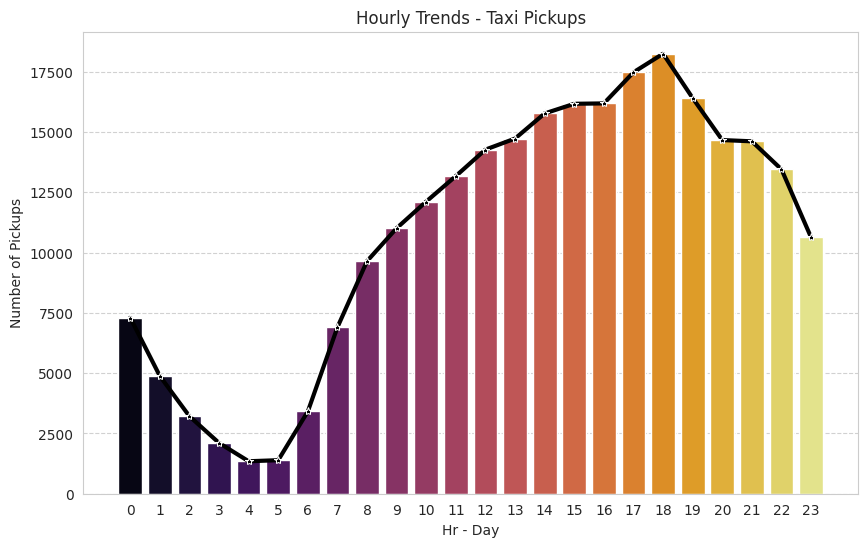

In [336]:
# Find and show the hourly trends in taxi pickups

# Find and show the hourly trends in taxi pickups
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
hourly_pickups = df.groupby("pickup_hour").size()

# Plotting the hourly trends
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.barplot(x=hourly_pickups.index, y=hourly_pickups.values, palette="inferno")
sns.lineplot(x=hourly_pickups.index, y=hourly_pickups.values, color='black', marker='*', linewidth=3)

# Labels and title
plt.xlabel('Hr - Day')
plt.ylabel('Number of Pickups')
plt.title('Hourly Trends - Taxi Pickups')
plt.xticks(range(24))  # Show all hours from 0 to 23
plt.grid(axis='y', linestyle='--', alpha=0.9)

plt.show()

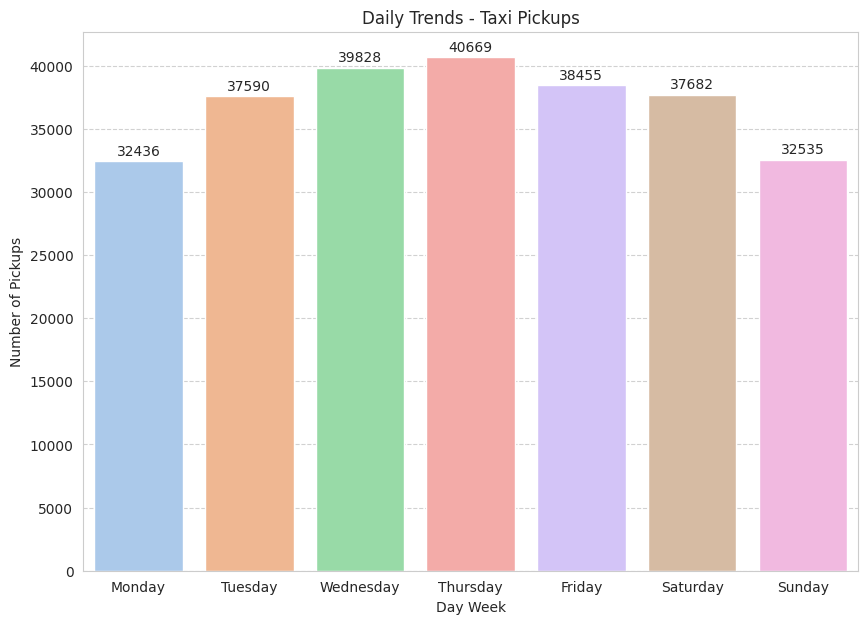

In [337]:
# Find and show the daily trends in taxi pickups (days of the week)
# Extract the day of the week (0=Monday, 6=Sunday)
df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.dayofweek
# Define day labels
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Group by day and count pickups
daily_pickups = df.groupby('pickup_day').size()
# Plot the daily trends
plt.figure(figsize=(10, 7))
sns.barplot(x=days, y=daily_pickups.values, palette="pastel")
# Labels and title
plt.xlabel('Day Week')
plt.ylabel('Number of Pickups')
plt.title('Daily Trends - Taxi Pickups')
plt.grid(axis='y', linestyle='--', alpha=0.9)
# Show the values on top of bars
for i, val in enumerate(daily_pickups):
    plt.text(i, val + 500, str(val), ha='center', fontsize=10)
plt.show()

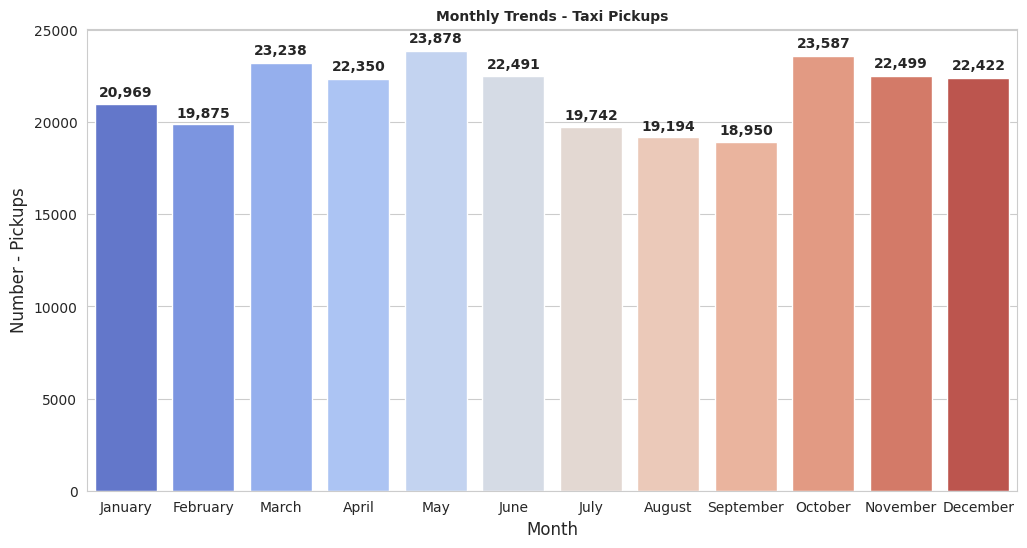

In [338]:
# Show the monthly trends in pickups
# Extract the month from datetime
df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month

# Count pickups per month
monthly_pickups = df['pickup_month'].value_counts().sort_index()

# Plot the monthly trends
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_pickups.index, y=monthly_pickups.values, palette="coolwarm")

# Add labels and title
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number - Pickups", fontsize=12)
plt.title("Monthly Trends - Taxi Pickups", fontsize=10, fontweight='bold')

# Correct x-axis labels
plt.xticks(ticks=range(12), labels=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], fontsize=10)

# Show values on top of bars
for i, val in enumerate(monthly_pickups.values):
    plt.text(i, val * 1.02, f"{val:,}", ha='center', fontsize=10, fontweight='bold')

plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [339]:
# Analyse the above parameters
# List of financial columns to check
financial_columns = ["fare_amount", "tip_amount", "total_amount", "trip_distance"]

# Count zero values
zero_counts = (df[financial_columns] == 0).sum()

# Count negative values
negative_counts = (df[financial_columns] < 0).sum()

# Display results
print("Zero Values in Financial Columns:")
print(zero_counts)
print("\nNegative Values in Financial Columns:")
print(negative_counts)



Zero Values in Financial Columns:
fare_amount          0
tip_amount       59977
total_amount         9
trip_distance     3423
dtype: int64

Negative Values in Financial Columns:
fare_amount         0
tip_amount         11
total_amount     2633
trip_distance       0
dtype: int64


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [399]:
# Create a df with non zero entries for the selected parameters.
# Define columns to filter
filter_columns = ["fare_amount", "total_amount", "trip_distance"]
# Count zero values before filtering
zero_counts_before = (df[filter_columns] == 0).sum()
print("Zero - Before Filtering:")
print(zero_counts_before)
# Remove rows where fare_amount or total_amount is zero
filtered_taxi_data = df[
    (df["fare_amount"] > 0) &
    (df["total_amount"] > 0)
]
# Handling trip_distance:

filtered_taxi_data = filtered_taxi_data[(filtered_taxi_data["trip_distance"] > 0) |
 (filtered_taxi_data["fare_amount"] > 0)]
# Count zero values after filtering
zero_counts_after = (filtered_taxi_data[filter_columns] == 0).sum()
print("\nZero value:")
print(zero_counts_after)

# Handling trip_distance -ve value:
# Count zero values after filtering



Zero - Before Filtering:
fare_amount         0
total_amount        9
trip_distance    3423
dtype: int64

Zero value:
fare_amount         0
total_amount        0
trip_distance    3120
dtype: int64

neg value:
fare_amount      0
total_amount     0
trip_distance    0
dtype: int64


In [341]:
filtered_taxi_data[(filtered_taxi_data[filter_columns] == 0).any(axis=1)]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
42             1  2023-01-01 01:15:59   2023-01-01 01:17:29                1   
62             1  2023-01-01 01:42:33   2023-01-01 01:43:18                1   
132            2  2023-01-01 03:15:58   2023-01-01 03:16:06                2   
169            2  2023-01-01 06:53:27   2023-01-01 06:53:33                1   
186            2  2023-01-01 08:23:37   2023-01-01 08:24:26                1   
...          ...                  ...                   ...              ...   
267462         1  2023-12-30 19:33:42   2023-12-30 19:33:42                4   
267645         1  2023-12-31 01:08:14   2023-12-31 01:30:21                1   
267759         2  2023-12-31 11:53:51   2023-12-31 11:53:58                3   
267817         2  2023-12-31 13:58:52   2023-12-31 13:58:55                4   
267969         1  2023-12-31 18:27:51   2023-12-31 18:35:59                1   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
42                0.0           1           148           148             1   
62                0.0           5            79            79             1   
132               0.0           5           100           100             1   
169               0.0           5            48            48             1   
186               0.0           1           193           193             4   
...               ...         ...           ...           ...           ...   
267462            0.0           1           142           264             2   
267645            0.0           1           114           106             1   
267759            0.0           5           142           142             1   
267817            0.0           1           163           163             2   
267969            0.0           1           145           145             2   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
42              3.7    3.5      0.5        0.00           0.0   
62             35.0    0.0      0.0        0.00           0.0   
132            30.0    0.0      0.0        6.20           0.0   
169            40.0    0.0      0.0        4.00           0.0   
186             3.0    0.0      0.5        0.00           0.0   
...             ...    ...      ...         ...           ...   
267462         12.1    2.5      0.5        0.00           0.0   
267645         13.5    3.5      0.5        5.50           0.0   
267759         50.0    0.0      0.0       13.38           0.0   
267817          3.0    0.0      0.5        0.00           0.0   
267969          7.9    0.0      0.5        0.00           0.0   

        improvement_surcharge  total_amount  congestion_surcharge  \
42                        1.0          8.70                   2.5   
62                        1.0         36.00                   0.0   
132                       1.0         37.20                   0.0   
169                       1.0         47.50                   2.5   
186                       1.0          4.50                   0.0   
...                       ...           ...                   ...   
267462                    1.0         16.10                   2.5   
267645                    1.0         24.00                   2.5   
267759                    1.0         66.88                   2.5   
267817                    1.0          7.00                   2.5   
267969                    1.0          9.40                   0.0   

        Airport_fee_new  pickup_hour  pickup_day  pickup_month  
42                  0.0            1           6             1  
62                  0.0            1           6             1  
132                 0.0            3           6             1  
169                 0.0            6           6             1  
186                 0.0            8           6             1  
...                 ...          ...         ...           ...  
267462              0.0          

In [342]:
filtered_taxi_data = filtered_taxi_data[~((filtered_taxi_data["trip_distance"] == 0) & (filtered_taxi_data["PULocationID"] != filtered_taxi_data["DOLocationID"]))]

In [400]:
financial_columns = ["fare_amount", "tip_amount", "total_amount", "trip_distance"]

# Count zero values
zero= (filtered_taxi_data[financial_columns] == 0).sum()
print("\nzero value:")
print(zero)
neg_counts_after = (filtered_taxi_data[filter_columns] < 0).sum()
print("\nneg value:")
print(neg_counts_after)



zero value:
fare_amount          0
tip_amount       57386
total_amount         0
trip_distance     3120
dtype: int64

neg value:
fare_amount      0
total_amount     0
trip_distance    0
dtype: int64


In [344]:
filtered_taxi_data.describe()

VendorID  passenger_count  trip_distance  RatecodeID  \
count  255465.000000         255465.0  255465.000000    255465.0   
mean        1.738493         1.387431       3.461096    1.073376   
std         0.439457         0.878169       4.582953    0.387561   
min         1.000000              1.0       0.000000         1.0   
25%         1.000000              1.0       1.060000         1.0   
50%         2.000000              1.0       1.780000         1.0   
75%         2.000000              1.0       3.400000         1.0   
max         2.000000              6.0     209.800000         6.0   

        PULocationID   DOLocationID   payment_type    fare_amount  \
count  255465.000000  255465.000000  255465.000000  255465.000000   
mean      165.292835     164.333071       1.204920      19.731350   
std        63.726948      69.721498       0.466356      18.355989   
min         1.000000       1.000000       1.000000       0.010000   
25%       132.000000     114.000000       1.000000       9.300000   
50%       162.000000     162.000000       1.000000      13.500000   
75%       234.000000     234.000000       1.000000      21.900000   
max       265.000000     265.000000       4.000000     715.600000   

               extra        mta_tax     tip_amount   tolls_amount  \
count  255465.000000  255465.000000  255465.000000  255465.000000   
mean        1.638682       0.495586       3.580680       0.591743   
std         1.835520       0.046807       4.037167       2.158280   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.500000       1.000000       0.000000   
50%         1.000000       0.500000       2.860000       0.000000   
75%         2.500000       0.500000       4.450000       0.000000   
max        11.750000       0.800000     100.000000      72.000000   

       improvement_surcharge   total_amount  congestion_surcharge  \
count          255465.000000  255465.000000         255465.000000   
mean                0.999628      28.862340              2.312655   
std                 0.016710      22.977555              0.658229   
min                 0.000000       1.000000              0.000000   
25%                 1.000000      15.960000              2.500000   
50%                 1.000000      21.000000              2.500000   
75%                 1.000000      30.700000              2.500000   
max                 1.000000     724.150000              2.500000   

       Airport_fee_new    pickup_hour     pickup_day   pickup_month  
count    255465.000000  255465.000000  255465.000000  255465.000000  
mean          0.142837      14.300648       2.997702       6.512266  
std           0.464465       5.779386       1.928332       3.463753  
min           0.000000       0.000000       0.000000       1.000000  
25%           0.000000      11.000000       1.000000       4.000000  
50%           0.000000      15.000000       3.000000       6.000000  
75%           0.000000      19.000000       5.000000      10.000000  
max           1.750000      23.000000       6.000000      12.000000

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

pickup_month
1     569395.55
2     533421.83
3     644204.55
4     635426.33
5     686340.97
6     648872.29
7     565697.47
8     550906.86
9     559581.45
10    692456.42
11    643417.92
12    643596.05
Name: total_amount, dtype: float64


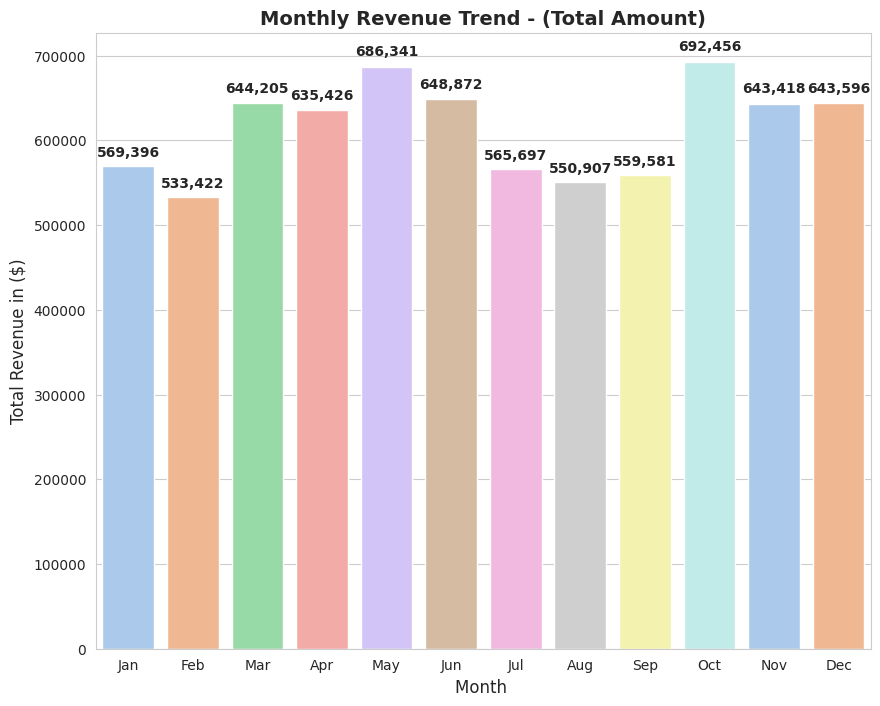

In [345]:
# Group data by month and analyse monthly revenue

# Group by month and calculate total revenue
monthly_revenue = filtered_taxi_data.groupby('pickup_month')['total_amount'].sum().sort_index()
print(monthly_revenue)
# Plot the revenue trend
plt.figure(figsize=(10, 8))
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette="pastel", order=range(1, 13))

# Add labels and title
plt.xlabel("Month ", fontsize=12)
plt.ylabel("Total Revenue in ($)", fontsize=12)
plt.title("Monthly Revenue Trend - (Total Amount)", fontsize=14, fontweight='bold')

# Format x-axis labels
plt.xticks(ticks=range(12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], fontsize=10)

# Show values on top of bars
for i, val in enumerate(monthly_revenue.values):
    plt.text(i, val * 1.02, f"{val:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

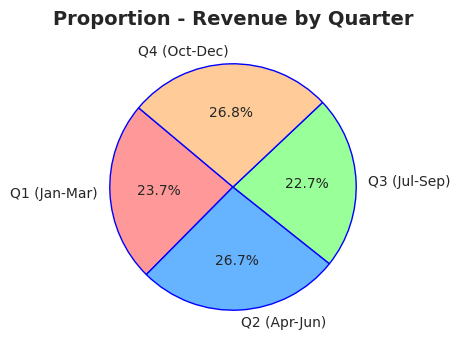

In [346]:
# Calculate proportion of each quarter

filtered_taxi_data['quarter'] = pd.to_datetime(filtered_taxi_data['tpep_pickup_datetime']).dt.quarter
quarterly_revenue = filtered_taxi_data.groupby('quarter')['total_amount'].sum()

# Define Labels and Colors
labels = ["Q1 (Jan-Mar)", "Q2 (Apr-Jun)", "Q3 (Jul-Sep)", "Q4 (Oct-Dec)"]

# Plot the Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(quarterly_revenue, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], startangle=140, wedgeprops={'edgecolor': 'blue'})

# Title and Show
plt.title("Proportion - Revenue by Quarter", fontsize=14, fontweight='bold')
plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Correlation between trip_distance and fare_amount: 0.9436


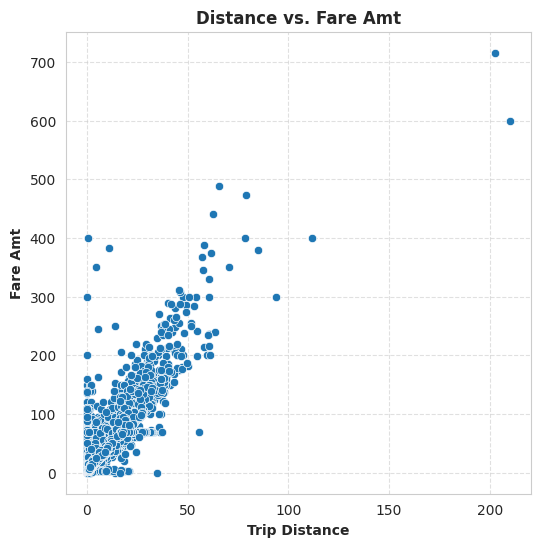

In [347]:
# Show how trip fare is affected by distance
# Step 1: Filter out invalid distances
filtered_df = filtered_taxi_data[filtered_taxi_data['trip_distance'] > 0]

# Step 2: Compute correlation
correlation = filtered_df["trip_distance"].corr(filtered_df["fare_amount"])
print(f"Correlation between trip_distance and fare_amount: {correlation:.4f}")

# Step 3: Create the figure
plt.figure(figsize=(6, 6))

# Step 4: Scatter plot with transparency for clarity
sns.scatterplot(
    x="trip_distance",
    y="fare_amount",
    data=filtered_df,
)
# Step 6: Customize labels and titles
plt.xlabel("Trip Distance", fontsize=10, fontweight='bold')
plt.ylabel("Fare Amt", fontsize=10, fontweight='bold')
plt.title("Distance vs. Fare Amt", fontsize=12, fontweight='bold')

# Step 7: Grid and Adjust Layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [348]:
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

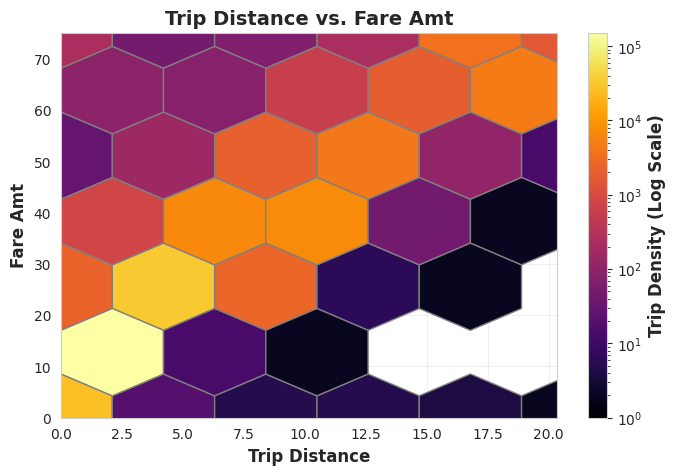

In [349]:
# Show relationship between fare and trip duration
# Step 1: Create hexbin plot
plt.figure(figsize=(8, 5))

hb = plt.hexbin(
    filtered_df["trip_distance"],
    filtered_df["fare_amount"],
    gridsize=50,  # Increase for better detail
    cmap="inferno",  # More readable colors
    mincnt=1,  # Avoid empty bins
    edgecolors="gray",  # Improve hexagon visibility
  norm=mcolors.LogNorm()  # Log scale for density visibility
)

# Step 2: Add color bar
cb = plt.colorbar(hb, label="Density - Trips")
cb.set_label("Trip Density (Log Scale)", fontsize=12, fontweight="bold")

# Step 3: Customize axes and title
plt.xlabel("Trip Distance", fontsize=12, fontweight="bold")
plt.ylabel("Fare Amt", fontsize=12, fontweight="bold")
plt.title("Trip Distance vs. Fare Amt", fontsize=14, fontweight="bold")

# Step 4: Limit outliers
plt.xlim(0, filtered_df["trip_distance"].quantile(0.99))
plt.ylim(0, filtered_df["fare_amount"].quantile(0.99))

# Step 5: Add light grid
plt.grid(alpha=0.3)

# Step 6: Show the plot
plt.show()

Correlation between trip_duration & fare_amount: 0.26


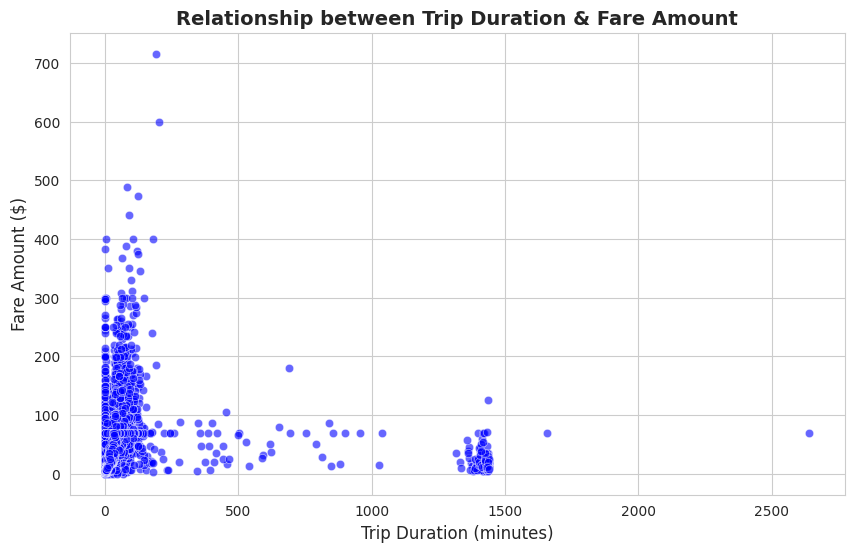

In [350]:
# Show relationship between fare and number of passengers
filtered_taxi_data['tpep_pickup_datetime'] = pd.to_datetime(filtered_taxi_data['tpep_pickup_datetime'])
filtered_taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(filtered_taxi_data['tpep_dropoff_datetime'])
filtered_taxi_data['trip_duration'] = (filtered_taxi_data['tpep_dropoff_datetime'] - filtered_taxi_data['tpep_pickup_datetime']).dt.total_seconds() /60 # Convert to minutes

# Filter out rows with zero or negative duration (if any)
filtered_df = filtered_taxi_data[filtered_taxi_data['trip_duration'] > 0]

# Calculate the correlation coefficient between trip_duration and fare_amount
correlation = filtered_df['trip_duration'].corr(filtered_df['fare_amount'])
print(f"Correlation between trip_duration & fare_amount: {correlation:.2f}")

# Plot the scatter plot between fare amount and trip duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_df['trip_duration'], y=filtered_df['fare_amount'], color='blue', alpha=0.6)

# Add labels and title
plt.xlabel("Trip Duration (minutes)", fontsize=12)
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.title("Relationship between Trip Duration & Fare Amount", fontsize=14, fontweight='bold')
# Show the plot
plt.show()


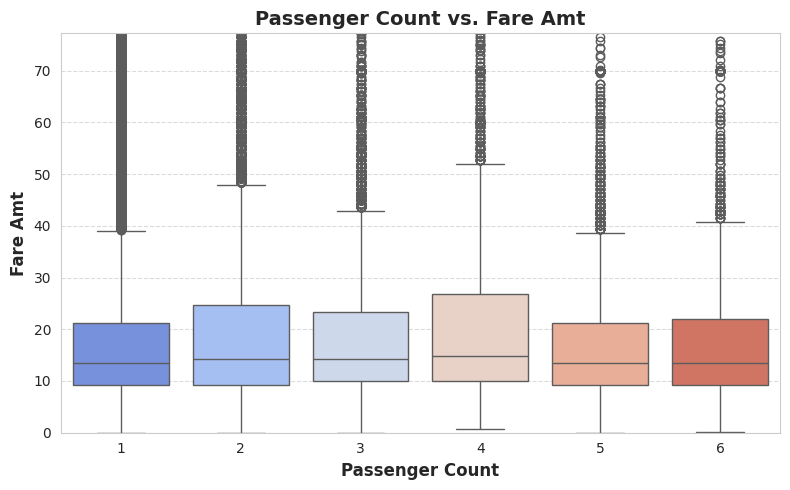

In [351]:
# Show relationship between tip and trip distance
plt.figure(figsize=(8, 5))

ax = sns.boxplot(
    data=filtered_taxi_data,
    x='passenger_count',
    y='fare_amount',
    palette="coolwarm",
    showfliers=True
)
plt.ylim(0, filtered_taxi_data["fare_amount"].quantile(0.99))

# Add title and labels
plt.title("Passenger Count vs. Fare Amt", fontsize=14, fontweight='bold')
plt.xlabel("Passenger Count", fontsize=12, fontweight='bold')
plt.ylabel("Fare Amt", fontsize=12, fontweight='bold')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


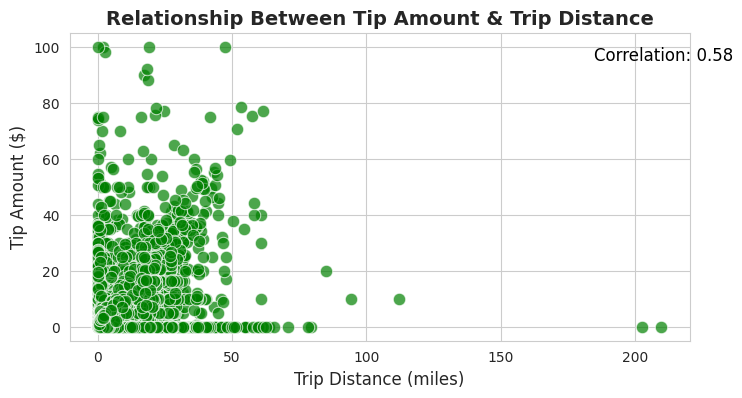

In [352]:
# Analyse the distribution of different payment types (payment_type).
plt.figure(figsize=(8, 4))
sns.scatterplot(x='trip_distance', y='tip_amount', data=filtered_taxi_data, color='green', s=80, alpha=0.7)

# Add labels and title
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Tip Amount ($)', fontsize=12)
plt.title('Relationship Between Tip Amount & Trip Distance', fontsize=14, fontweight='bold')

# Display correlation value
correlation = filtered_taxi_data['trip_distance'].corr(filtered_taxi_data['tip_amount'])
plt.figtext(0.78, 0.81, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

plt.show()



**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



In [353]:
payment_type_mapping = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}
filtered_taxi_data['payment_type'] = filtered_taxi_data['payment_type'].map(payment_type_mapping)
payment_counts = filtered_taxi_data['payment_type'].value_counts()
payment_percentage = filtered_taxi_data['payment_type'].value_counts(normalize=True) * 100
payment_counts

payment_type
Credit Card    208168
Cash            44160
Dispute          1916
No Charge        1221
Name: count, dtype: int64

In [354]:
payment_percentage

payment_type
Credit Card    81.485918
Cash           17.286125
Dispute         0.750005
No Charge       0.477952
Name: proportion, dtype: float64

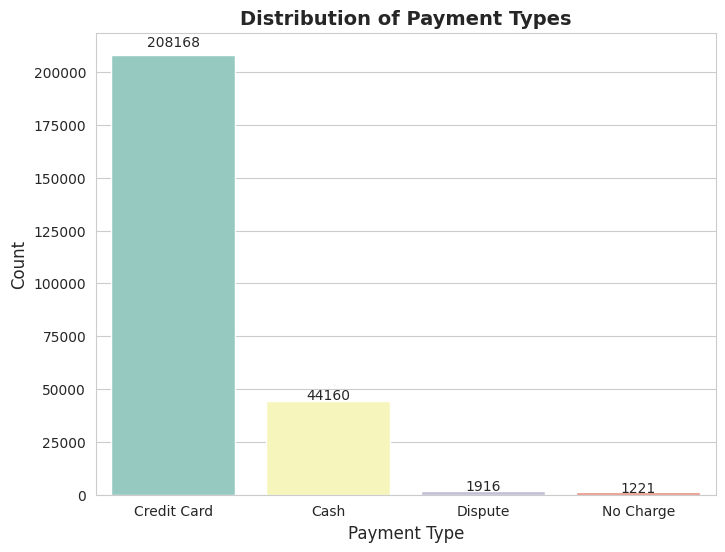

In [355]:
# Count the occurrences of each payment type
payment_type_counts = filtered_taxi_data['payment_type'].value_counts()

# Plot the distribution of payment types
plt.figure(figsize=(8, 6))
sns.barplot(x=payment_type_counts.index, y=payment_type_counts.values, palette='Set3')

# Add labels and title
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Payment Types', fontsize=14, fontweight='bold')

# Show values on top of bars
for i, val in enumerate(payment_type_counts.values):
    plt.text(i, val * 1.02, str(val), ha='center', fontsize=10)

plt.show()

##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [356]:
 !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [357]:
 import geopandas as gpd

In [358]:
# Read the shapefile using geopandas
zones = gpd.read_file("/content/drive/MyDrive/EDA_Assignment/Shape/taxi_zones/taxi_zones.shp") # read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


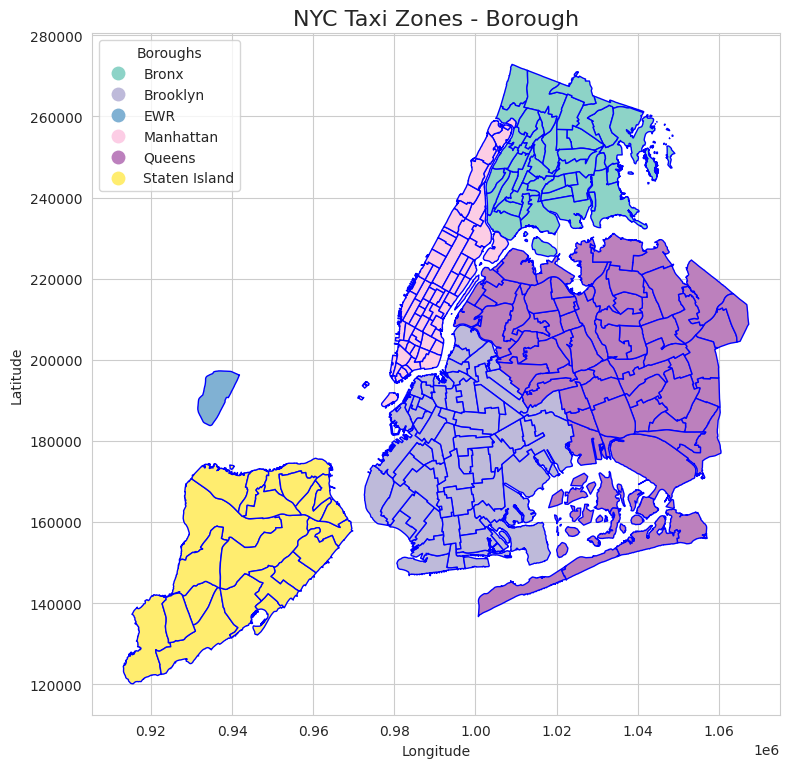

In [359]:
# print(zones.info())
print(zones.info())
fig, ax = plt.subplots(figsize=(8, 8))

zones.plot(
    column="borough",
    cmap="Set3",
    edgecolor="blue",
    legend=True,
    ax=ax,
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (0, 1),
        'title': 'Boroughs'
    }
)

ax.set_title("NYC Taxi Zones - Borough", fontsize=16)
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

plt.tight_layout()
plt.show() # zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [360]:
# Merge zones and trip records using locationID and PULocationID

taxi_data_zones_merged = filtered_taxi_data.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")

# Check the merged DataFrame
taxi_data_zones_merged.head()


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:30   2023-01-01 00:11:49                1   
1         2  2023-01-01 00:49:02   2023-01-01 00:55:15                1   
2         1  2023-01-01 00:47:17   2023-01-01 01:07:01                2   
3         2  2023-01-01 00:06:02   2023-01-01 00:31:38                1   
4         2  2023-01-01 00:02:19   2023-01-01 00:30:49                1   

   trip_distance  RatecodeID  PULocationID  DOLocationID payment_type  \
0           0.49           1           239           238  Credit Card   
1           0.75           1            45           148         Cash   
2           2.90           1           142           170  Credit Card   
3           2.50           1            43           161  Credit Card   
4          20.37           2           132           140  Credit Card   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0          4.4    1.0      0.5        1.88          0.00   
1          7.9    1.0      0.5        0.00          0.00   
2         19.1    3.5      0.5        4.80          0.00   
3         24.0    1.0      0.5        7.25          0.00   
4         70.0    0.0      0.5       12.00          6.55   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee_new  \
0                    1.0         11.28                   2.5              0.0   
1                    1.0         12.90                   2.5              0.0   
2                    1.0         28.90                   2.5              0.0   
3                    1.0         36.25                   2.5              0.0   
4                    1.0         92.55                   2.5              0.0   

   pickup_hour  pickup_day  pickup_month  quarter  trip_duration  OBJECTID  \
0            0           6             1        1       1.316667     239.0   
1            0           6             1        1       6.216667      45.0   
2            0           6             1        1      19.733333     142.0   
3            0           6             1        1      25.600000      43.0   
4            0           6             1        1      28.500000     132.0   

   Shape_Leng  Shape_Area                   zone  LocationID    borough  \
0    0.063626    0.000205  Upper West Side South       239.0  Manhattan   
1    0.045907    0.000091              Chinatown        45.0  Manhattan   
2    0.038176    0.000076    Lincoln Square East       142.0  Manhattan   
3    0.099739    0.000380           Central Park        43.0  Manhattan   
4    0.245479    0.002038            JFK Airport       132.0     Queens   

                                            geometry  
0  POLYGON ((991168.979 226252.992, 991955.565 22...  
1  POLYGON ((984941.821 199431.157, 984958.446 19...  
2  POLYGON ((989380.305 218980.247, 989359.803 21...  
3  POLYGON ((991852.973 217950.807, 991725.244 21...  
4  MULTIPOLYGON (((1032791.001 181085.006, 103283...

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [361]:
# Group data by location and calculate the number of trips

trips_per_location = taxi_data_zones_merged.groupby("PULocationID").size().reset_index(name="num_trips")

# Merge with taxi_data_zones_merged to get zone names
trips_per_location = trips_per_location.merge(
    taxi_data_zones_merged[["PULocationID", "zone"]].drop_duplicates(),
    on="PULocationID",
    how="left"
)

# Sort by most popular locations
trips_per_location = trips_per_location.sort_values(by="num_trips", ascending=False)

# Display the top 10 locations with zone names
trips_per_location[['PULocationID','zone','num_trips']].head(10)

PULocationID                          zone  num_trips
118           132                   JFK Airport      13529
216           237         Upper East Side South      12070
146           161                Midtown Center      11817
215           236         Upper East Side North      10877
147           162                  Midtown East       9114
169           186  Penn Station/Madison Sq West       8910
124           138             LaGuardia Airport       8904
128           142           Lincoln Square East       8529
209           230     Times Sq/Theatre District       8383
148           163                 Midtown North       7648

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [362]:
# Merge trip counts back to the zones GeoDataFrame

zones = zones.merge(trips_per_location, left_on="LocationID", right_on="PULocationID", how="left")

# Fill NaN values (for locations with no trips) with 0
zones["num_trips"] = zones["num_trips"].fillna(0)
zones.head()



OBJECTID  Shape_Leng  Shape_Area                   zone_x  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   PULocationID  num_trips                   zone_y  
0           1.0       35.0           Newark Airport  
1           NaN        0.0                      NaN  
2           3.0        4.0  Allerton/Pelham Gardens  
3           4.0      253.0            Alphabet City  
4           5.0        3.0            Arden Heights

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

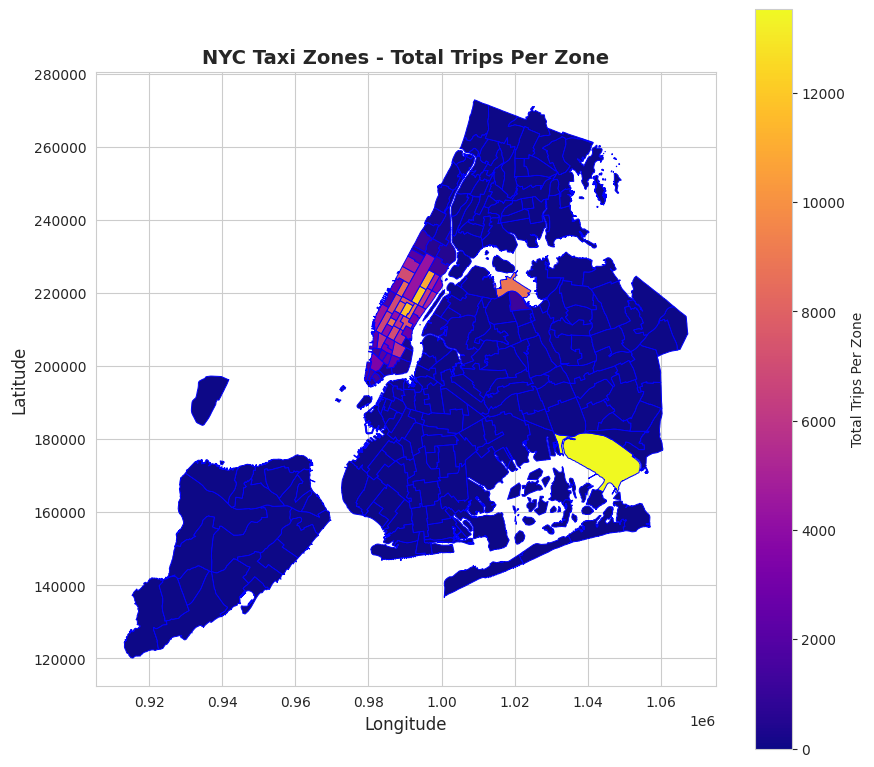

In [363]:
# Define figure and axis


# Plot the map and display it
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

# Plot NYC taxi zones colored by the number of trips
zones.sort_values(by="num_trips", ascending=False).plot(column="num_trips", cmap="plasma", edgecolor="blue", linewidth=0.7,
           legend=True, ax=ax,
       legend_kwds={'label': "Total Trips Per Zone", 'orientation': "vertical",'shrink': 0.48})

# Title and labels
plt.title("NYC Taxi Zones - Total Trips Per Zone", fontsize=14, fontweight='bold')
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show plot
plt.show()


In [364]:
# can you try displaying the zones DF sorted by the number of trips?
zones_sorted = zones.sort_values(by="num_trips", ascending=False)
zones_sorted[["LocationID", "borough", "zone_x", "num_trips"]].head(10)


LocationID    borough                        zone_x  num_trips
131         132     Queens                   JFK Airport    13529.0
236         237  Manhattan         Upper East Side South    12070.0
160         161  Manhattan                Midtown Center    11817.0
235         236  Manhattan         Upper East Side North    10877.0
161         162  Manhattan                  Midtown East     9114.0
185         186  Manhattan  Penn Station/Madison Sq West     8910.0
137         138     Queens             LaGuardia Airport     8904.0
141         142  Manhattan           Lincoln Square East     8529.0
229         230  Manhattan     Times Sq/Theatre District     8383.0
162         163  Manhattan                 Midtown North     7648.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [365]:
# Find routes which have the slowest speeds at different times of the day

taxi_data_zones_merged['trip_duration_hours'] = (taxi_data_zones_merged['tpep_dropoff_datetime'] -
                                             taxi_data_zones_merged['tpep_pickup_datetime']).dt.total_seconds() / 3600
df_filtered_clean = taxi_data_zones_merged[(taxi_data_zones_merged["trip_duration_hours"] > 0) & (taxi_data_zones_merged["trip_distance"] > 0)]

# Group by route and hour again with cleaned data
route_speed_clean = df_filtered_clean.groupby(["PULocationID", "DOLocationID", "pickup_hour"]).agg(
    avg_duration=("trip_duration_hours", "mean"),  # Average trip duration per route-hour
    total_distance=("trip_distance", "mean")  # Total distance per route-hour
).reset_index()

# Compute speed (distance / avg duration)
route_speed_clean["avg_speed"] = route_speed_clean["total_distance"] / (route_speed_clean["avg_duration"] + 1e-5)  # Avoid division by zero

# Find the slowest routes (smallest speed)
slowest_routes_clean = route_speed_clean.sort_values(by="avg_speed", ascending=True).head(10)  # Adjust for top N slowest routes

# Display the cleaned slowest routes
slowest_routes_clean


PULocationID  DOLocationID  pickup_hour  avg_duration  total_distance  \
9010             75           249           22      2.982500            0.01   
46143           230           229            4     23.487778            1.00   
337              10           145           11      1.671111            0.10   
37030           163           237            2     23.822222            1.46   
58492           262           238           11     23.205278            1.81   
5                 1           264           11      0.114722            0.01   
44634           229           163            2     11.970417            1.08   
47968           233            43           22     23.596111            2.14   
6516             68           137            1     23.828333            2.25   
32568           158           100            3     22.915833            2.22   

       avg_speed  
9010    0.003353  
46143   0.042575  
337     0.059840  
37030   0.061287  
58492   0.077999  
5       0.087159  
44634   0.090222  
47968   0.090693  
6516    0.094425  
32568   0.096876

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

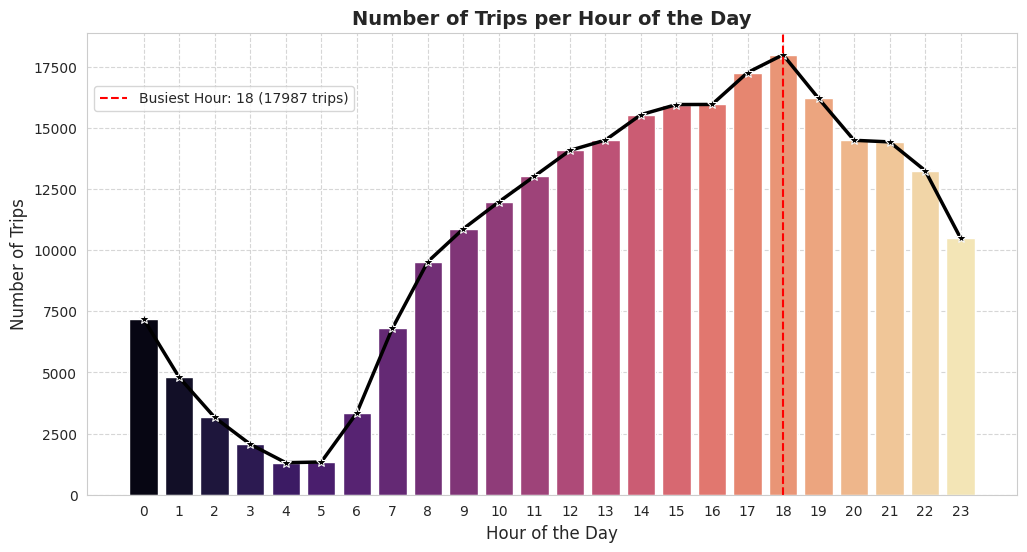

(np.int32(18), 17987)

In [366]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour = taxi_data_zones_merged.groupby('pickup_hour').size()

# Find the busiest hour
busiest_hour = trips_per_hour.idxmax()  # Hour with max trips
busiest_hour_trips = trips_per_hour.max()  # Number of trips in that hour

# Create the figure
plt.figure(figsize=(12, 6))

# Bar plot for the number of trips per hour
sns.barplot(x=trips_per_hour.index, y=trips_per_hour.values, palette='magma')

# Line plot to show the trend
sns.lineplot(x=trips_per_hour.index, y=trips_per_hour.values, color="black", marker="*",markersize=8, linewidth=2.5)

# Highlight the busiest hour with a vertical line
plt.axvline(x=busiest_hour, color='red', linestyle='--', label=f'Busiest Hour: {busiest_hour} ({busiest_hour_trips} trips)')

# Add labels and title
plt.title('Number of Trips per Hour of the Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.grid(True, linestyle="--", alpha=0.8)
# Show the legend
plt.legend(loc="upper left", bbox_to_anchor=(0, 0.9), fontsize=10)

# Show the plot
plt.show()

# Return the busiest hour and its trip count
busiest_hour, busiest_hour_trips



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [367]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers

# Calculate the number of trips per hour
trip_count_per_hour = taxi_data_zones_merged.groupby('pickup_hour').size().reset_index(name='trip_count')

# Scale up the number of trips using the sampling fraction
sample_fraction = 0.008  # Replace this with your actual sampling fraction
trip_count_per_hour['actual_trip_count'] = (trip_count_per_hour['trip_count'] / sample_fraction).astype(int)

# Find the five busiest hours
top_5_hours = trip_count_per_hour.nlargest(5, 'trip_count')

# Display results
top_5_hours



pickup_hour  trip_count  actual_trip_count
18           18       17987            2248375
17           17       17257            2157125
19           19       16200            2025000
16           16       15954            1994250
15           15       15950            1993750

In [368]:
taxi_data_zones_merged.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee_new',
 'pickup_hour',
 'pickup_day',
 'pickup_month',
 'quarter',
 'trip_duration',
 'OBJECTID',
 'Shape_Leng',
 'Shape_Area',
 'zone',
 'LocationID',
 'borough',
 'geometry',
 'trip_duration_hours']

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

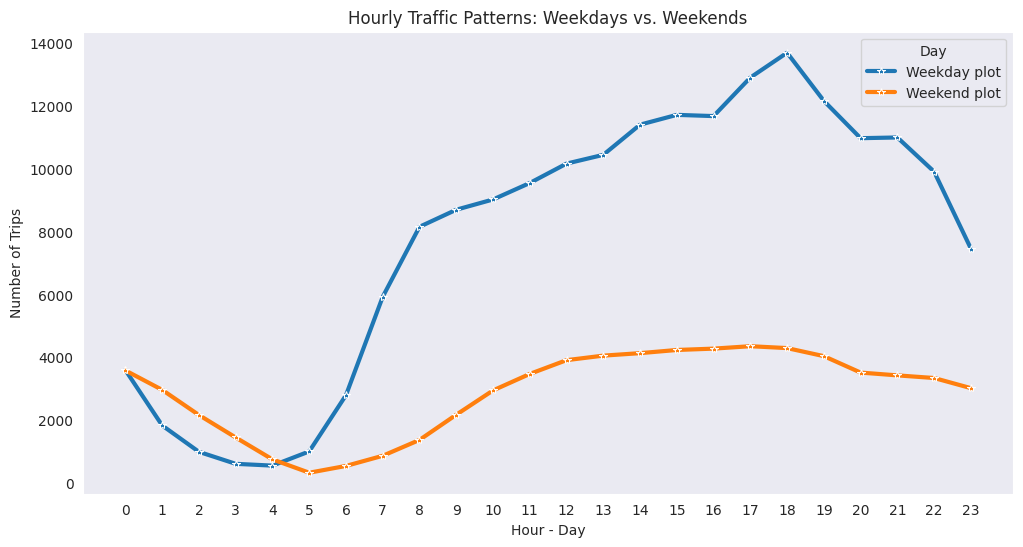

In [369]:
# Compare traffic trends for the week days and weekends
import matplotlib.pyplot as plt
import seaborn as sns

# Separate weekdays and weekends (Weekdays: 0-4, Weekends: 5-6)
weekdays = taxi_data_zones_merged[taxi_data_zones_merged['pickup_day'] <= 4]
weekends = taxi_data_zones_merged[taxi_data_zones_merged['pickup_day'] >= 5]

# Count the number of trips per hour for weekdays and weekends
weekday_counts = weekdays.groupby('pickup_hour').size()
weekend_counts = weekends.groupby('pickup_hour').size()

# Plot the data in one figure
plt.figure(figsize=(12, 6))
sns.set_style("dark")
# Weekday plot
sns.lineplot(x=weekday_counts.index, y=weekday_counts.values, marker='*', label="Weekday plot", linewidth=3)

# Weekend plot
sns.lineplot(x=weekend_counts.index, y=weekend_counts.values, marker='*', label="Weekend plot", linewidth=3)

# Titles and labels
plt.title("Hourly Traffic Patterns: Weekdays vs. Weekends")
plt.xlabel("Hour - Day")
plt.ylabel("Number of Trips")
plt.xticks(range(24))

# Legend
plt.legend(title="Day")

# Show the plot
plt.show()



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

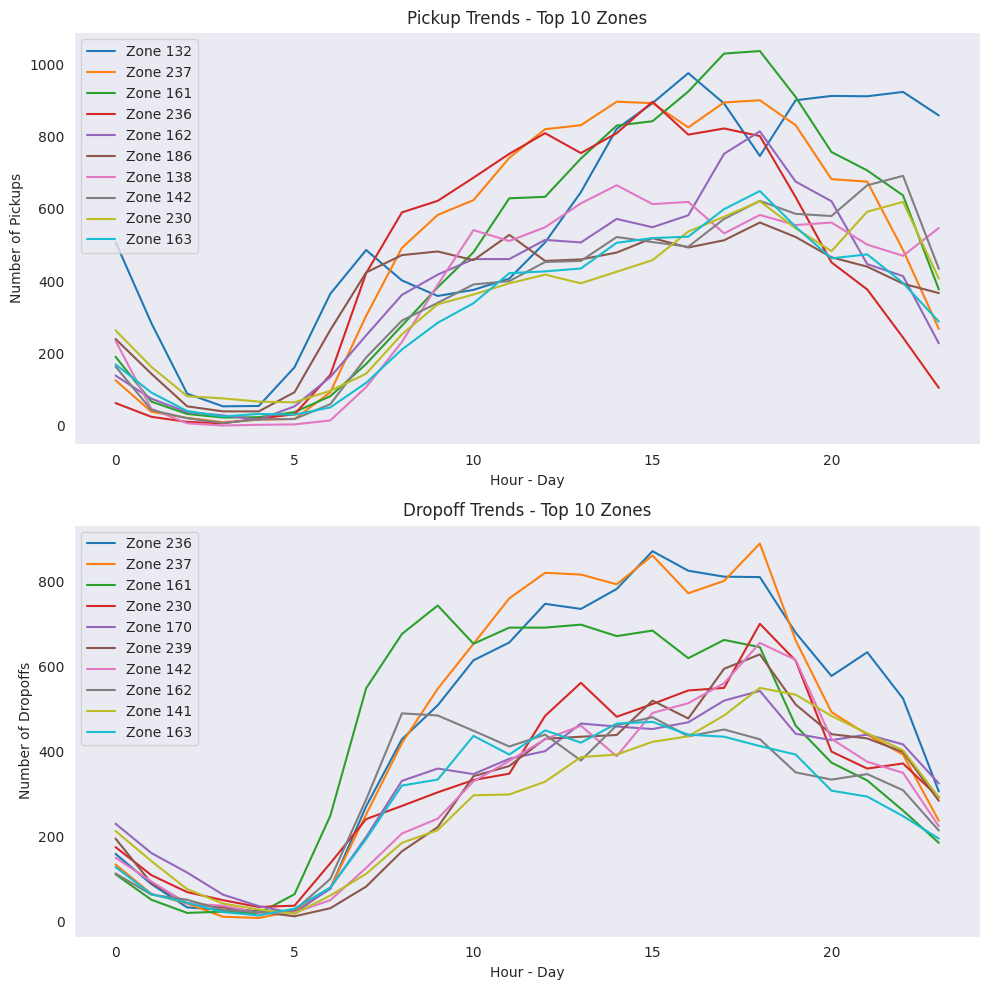

In [370]:
# Find top 10 pickup and dropoff zones

pickup_counts = taxi_data_zones_merged.groupby(['pickup_hour', 'PULocationID']).size().reset_index(name='pickup_count')
taxi_data_zones_merged['dropoff_hour'] = pd.to_datetime(taxi_data_zones_merged['tpep_dropoff_datetime']).dt.hour
# Group by Dropoff Hour and DOLocationID
dropoff_counts = taxi_data_zones_merged.groupby(['dropoff_hour', 'DOLocationID']).size().reset_index(name='dropoff_count')

# Find top 10 pickup zones by total pickups
top_pickup_zones = pickup_counts.groupby('PULocationID')['pickup_count'].sum().nlargest(10).index

# Find top 10 dropoff zones by total dropoffs
top_dropoff_zones = dropoff_counts.groupby('DOLocationID')['dropoff_count'].sum().nlargest(10).index

# Filter data for these top zones
pickup_top_zones = pickup_counts[pickup_counts['PULocationID'].isin(top_pickup_zones)]
dropoff_top_zones = dropoff_counts[dropoff_counts['DOLocationID'].isin(top_dropoff_zones)]

# Plot the pickup and dropoff trends for top 10 zones
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Pickup Trends for Top 10 Zones
for zone in top_pickup_zones:
    zone_data = pickup_top_zones[pickup_top_zones['PULocationID'] == zone]
    ax[0].plot(zone_data['pickup_hour'], zone_data['pickup_count'], label=f'Zone {zone}')

ax[0].set_title('Pickup Trends - Top 10 Zones')
ax[0].set_xlabel('Hour - Day')
ax[0].set_ylabel('Number of Pickups')
ax[0].legend(loc='upper left')

# Dropoff Trends for Top 10 Zones
for zone in top_dropoff_zones:
    zone_data = dropoff_top_zones[dropoff_top_zones['DOLocationID'] == zone]
    ax[1].plot(zone_data['dropoff_hour'], zone_data['dropoff_count'], label=f'Zone {zone}')

ax[1].set_title('Dropoff Trends - Top 10 Zones')
ax[1].set_xlabel('Hour - Day')
ax[1].set_ylabel('Number of Dropoffs')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [371]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_total = pickup_counts.groupby('PULocationID')['pickup_count'].sum()

# Calculate total dropoffs per zone
dropoff_total = dropoff_counts.groupby('DOLocationID')['dropoff_count'].sum()

# Combine pickup and dropoff data for each zone into a single DataFrame
zone_data = pd.DataFrame({'total_pickups': pickup_total, 'total_dropoffs': dropoff_total})

# Fill missing values with 0 (zones with only pickups or only dropoffs)
zone_data.fillna(0, inplace=True)

# Avoid division by zero (replace 0 dropoffs with a small number)
zone_data['total_dropoffs'] = zone_data['total_dropoffs'].replace(0, 1)

# Calculate the pickup to dropoff ratio for each zone
zone_data['pickup_dropoff_ratio'] = zone_data['total_pickups'] / zone_data['total_dropoffs']

# Sort by pickup/dropoff ratio (high to low)
top_10_ratios = zone_data.sort_values('pickup_dropoff_ratio', ascending=False).head(10)

# Sort by pickup/dropoff ratio (low to high)
bottom_10_ratios = zone_data.sort_values('pickup_dropoff_ratio', ascending=True).head(10)

# Display the top 10 and bottom 10 pickup/dropoff ratios
print("Top 10 Zones with the Highest Pickup/Dropoff Ratios:")
top_10_ratios


Top 10 Zones with the Highest Pickup/Dropoff Ratios:


total_pickups  total_dropoffs  pickup_dropoff_ratio
70          1170.0             168              6.964286
132        13529.0            2947              4.590770
138         8904.0            3102              2.870406
186         8910.0            5627              1.583437
43          4310.0            3105              1.388084
249         5710.0            4255              1.341951
114         3343.0            2505              1.334531
162         9114.0            7159              1.273083
100         4215.0            3545              1.188999
142         8529.0            7194              1.185571

In [372]:
print("\nTop ten Zones with the Lowest Pickup/Dropoff Ratios:")
bottom_10_ratios


Top ten Zones with the Lowest Pickup/Dropoff Ratios:


total_pickups  total_dropoffs  pickup_dropoff_ratio
245            0.0               3                   0.0
221            0.0               6                   0.0
240            0.0               9                   0.0
204            0.0               1                   0.0
172            0.0               3                   0.0
58             0.0               5                   0.0
54             0.0              56                   0.0
57             0.0               4                   0.0
156            0.0               4                   0.0
251            0.0               2                   0.0

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [373]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filter for night hours (11 PM to 5 AM)
night_hours = taxi_data_zones_merged[(taxi_data_zones_merged['pickup_hour'] >= 23) | (taxi_data_zones_merged['pickup_hour'] <= 5)]

# Group by PULocationID for pickups and DOLocationID for dropoffs
pickup_night_counts = night_hours.groupby('PULocationID').size().reset_index(name='pickup_count')
dropoff_night_counts = night_hours.groupby('DOLocationID').size().reset_index(name='dropoff_count')

# Merge with taxi zone lookup to get zone names
pickup_night_counts = pickup_night_counts.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')
dropoff_night_counts = dropoff_night_counts.merge(zones, left_on='DOLocationID', right_on='LocationID', how='left')

# Sort to get the top 10 zones
top_pickup_zones_night = pickup_night_counts.sort_values(by='pickup_count', ascending=False).head(10)
top_dropoff_zones_night = dropoff_night_counts.sort_values(by='dropoff_count', ascending=False).head(10)

# Select only relevant columns for display
top_pickup_zones_night = top_pickup_zones_night.rename(columns={'zone_x': 'Zone', 'PULocationID_x': 'PULocationID'})
top_dropoff_zones_night = top_dropoff_zones_night.rename(columns={'zone_x': 'Zone', 'DOLocationID': 'DOLocationID'})
top_pickup_zones_night = top_pickup_zones_night[['Zone', 'borough', 'PULocationID', 'pickup_count']]
top_dropoff_zones_night = top_dropoff_zones_night[['Zone', 'borough', 'DOLocationID', 'dropoff_count']]
# Display results
print("Top 10 Night Pickup Zones:")
top_pickup_zones_night



Top 10 Night Pickup Zones:


Zone    borough  PULocationID  pickup_count
45                   East Village  Manhattan            79          2161
72                    JFK Airport     Queens           132          2010
154                  West Village  Manhattan           249          1721
26                   Clinton East  Manhattan            48          1495
85                Lower East Side  Manhattan           148          1352
64        Greenwich Village South  Manhattan           114          1219
140     Times Sq/Theatre District  Manhattan           230          1124
109  Penn Station/Madison Sq West  Manhattan           186           978
98                  Midtown South  Manhattan           164           859
77              LaGuardia Airport     Queens           138           844

In [374]:
top_dropoff_zones_night

Zone    borough  DOLocationID  dropoff_count
76                    East Village  Manhattan            79           1169
45                    Clinton East  Manhattan            48            967
157                    Murray Hill  Manhattan           170            896
99                        Gramercy  Manhattan           107            806
65                    East Chelsea  Manhattan            68            795
128                Lenox Hill West  Manhattan           141            745
242                 Yorkville West  Manhattan           263            710
211      Times Sq/Theatre District  Manhattan           230            680
230                   West Village  Manhattan           249            655
210  Sutton Place/Turtle Bay North  Manhattan           229            649

<Figure size 960x720 with 0 Axes>

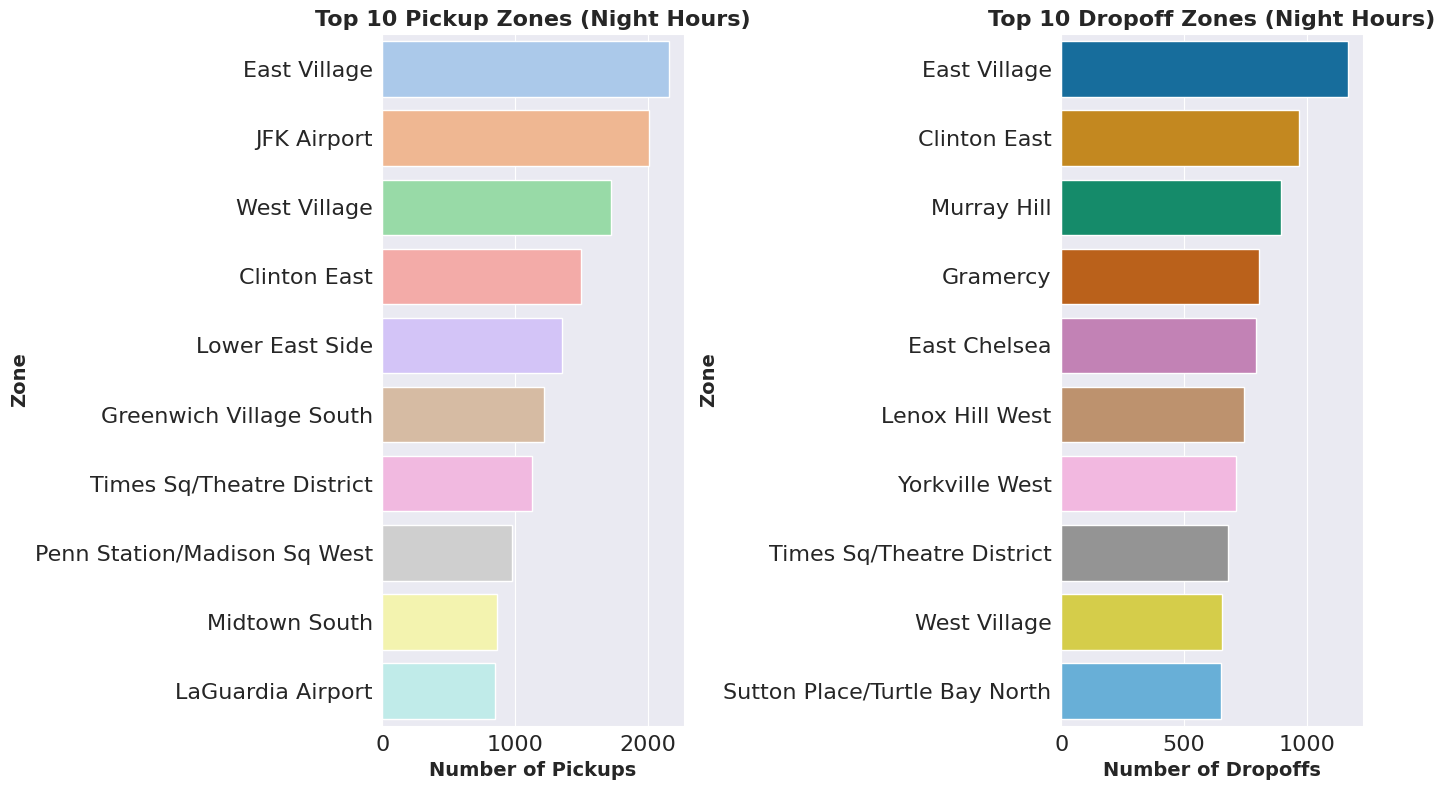

In [375]:
sns.set_style("darkgrid")
plt.figure(dpi=150)  # Increase DPI for better clarity

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14,8))

# Define font properties for better readability
title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 14, 'fontweight': 'bold'}
tick_fontsize = 16

# Plot Pickup Zones
sns.barplot(data=top_pickup_zones_night, x='pickup_count', y='Zone', ax=axes[0], palette="pastel")
axes[0].set_title('Top 10 Pickup Zones (Night Hours)', **title_font)
axes[0].set_xlabel('Number of Pickups', **label_font)
axes[0].set_ylabel('Zone', **label_font)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)

# Plot Dropoff Zones
sns.barplot(data=top_dropoff_zones_night, x='dropoff_count', y='Zone', ax=axes[1], palette="colorblind")
axes[1].set_title('Top 10 Dropoff Zones (Night Hours)', **title_font)
axes[1].set_xlabel('Number of Dropoffs', **label_font)
axes[1].set_ylabel('Zone', **label_font)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)

# Rotate Y-axis labels slightly for better readability
for ax in axes:
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [376]:
# Filter for night hours (11 PM to 5 AM)
# Night hours: 11 PM to 5 AM
night_hours_df = taxi_data_zones_merged[(taxi_data_zones_merged['pickup_hour'] >= 23) | (taxi_data_zones_merged['pickup_hour'] <= 5)]

# Day hours: 6 AM to 10 PM
day_hours_df = taxi_data_zones_merged[(taxi_data_zones_merged['pickup_hour'] >= 6) & (taxi_data_zones_merged['pickup_hour'] <= 22)]

# Calculate total revenue for night and day hours
total_revenue_night = night_hours_df['total_amount'].sum()
total_revenue_day = day_hours_df['total_amount'].sum()

# Calculate total revenue overall
total_revenue = taxi_data_zones_merged['total_amount'].sum()

# Calculate revenue share for night and day hours
night_revenue_share = total_revenue_night / total_revenue * 100
day_revenue_share = total_revenue_day / total_revenue * 100

print("night_rev_share:-", night_revenue_share.round(2),"day_rev_share:-", day_revenue_share.round(2))


night_rev_share:- 12.08 day_rev_share:- 87.92


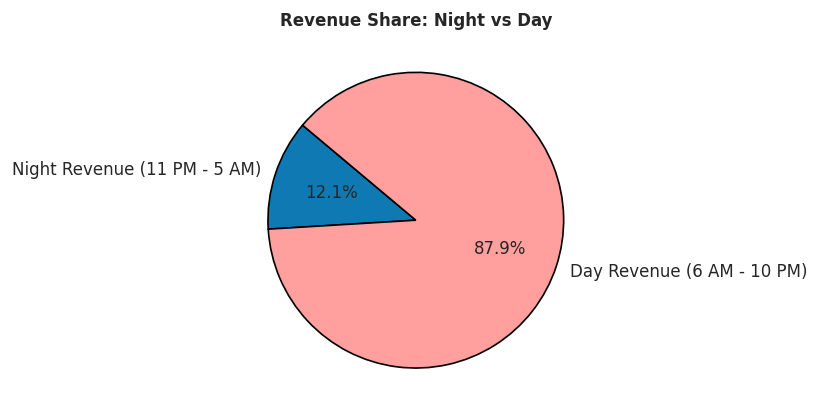

In [377]:
# Labels and values for the pie chart
labels = ['Night Revenue (11 PM - 5 AM)', 'Day Revenue (6 AM - 10 PM)']
values = [night_revenue_share, day_revenue_share]
colors = ['#0f79b4', '#ff9f9e']

# Create a pie chart
plt.figure(figsize=(4, 4), dpi=120)
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title and styling
plt.title('Revenue Share: Night vs Day', fontsize=10, fontweight='bold')
plt.show()

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

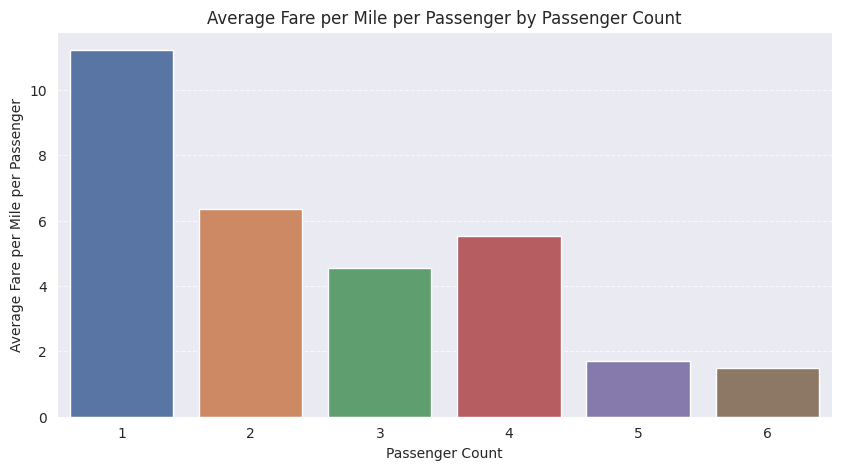

passenger_count  fare_per_mile_per_passenger
0                1                    11.212939
1                2                     6.364363
2                3                       4.5445
3                4                     5.525238
4                5                     1.695873
5                6                     1.478488

In [378]:
# Analyse the fare per mile per passenger for different passenger counts
taxi_data_zones_merged = taxi_data_zones_merged.loc[taxi_data_zones_merged['trip_distance'] > 0].copy()

# Compute fare per mile and fare per mile per passenger
taxi_data_zones_merged['fare_per_mile'] = taxi_data_zones_merged['fare_amount'] / taxi_data_zones_merged['trip_distance']
taxi_data_zones_merged['fare_per_mile_per_passenger'] = (
    taxi_data_zones_merged['fare_per_mile'] / taxi_data_zones_merged['passenger_count']
)

# Group by passenger count and compute average fare per mile per passenger
avg_fare_per_mile_per_passenger = taxi_data_zones_merged.groupby('passenger_count', as_index=False).agg(
    {'fare_per_mile_per_passenger': 'mean'}
)

# **Plotting the results**
plt.figure(figsize=(10, 5))
sns.barplot(
    data=avg_fare_per_mile_per_passenger,
    x='passenger_count',
    y='fare_per_mile_per_passenger',
    palette='deep'
)
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare per Mile per Passenger")
plt.title("Average Fare per Mile per Passenger by Passenger Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()
avg_fare_per_mile_per_passenger



In [379]:
taxi_data_zones_merged.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee_new', 'pickup_hour', 'pickup_day',
       'pickup_month', 'quarter', 'trip_duration', 'OBJECTID', 'Shape_Leng',
       'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry',
       'trip_duration_hours', 'dropoff_hour', 'fare_per_mile',
       'fare_per_mile_per_passenger'],
      dtype='object')

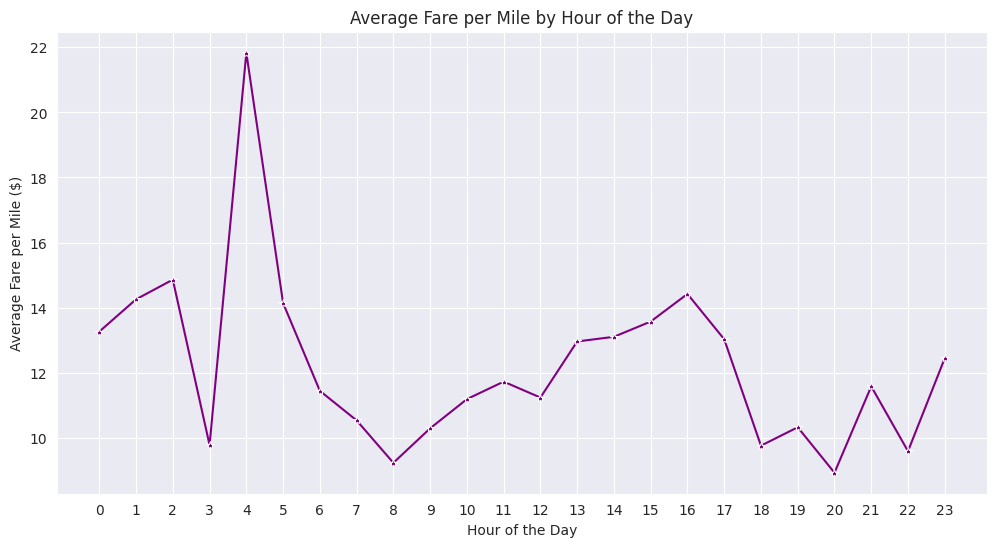

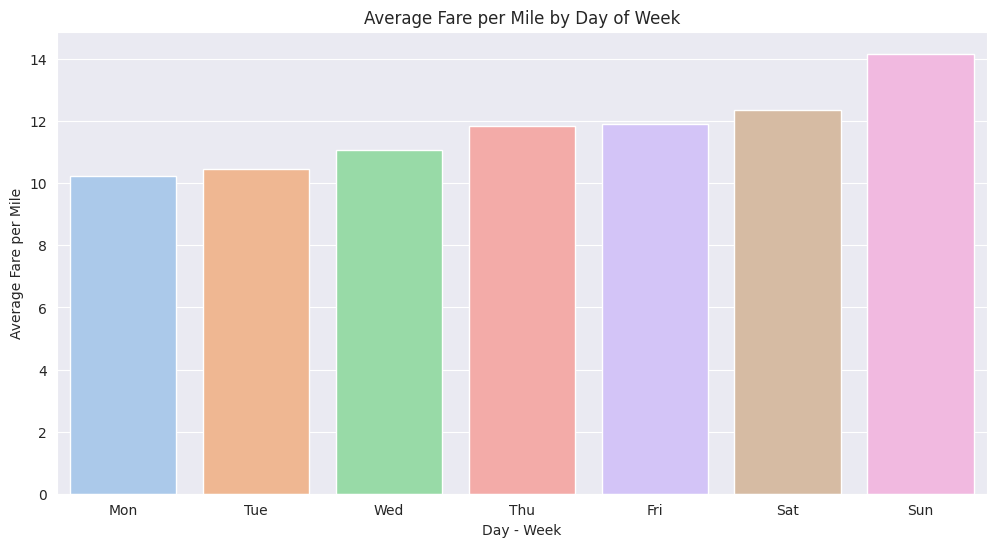

In [380]:
# Group by hour of the day and calculate average fare per mile
avg_fare_by_hour = taxi_data_zones_merged.groupby('pickup_hour')['fare_per_mile'].mean()

# Group by day of the week and calculate average fare per mile
avg_fare_by_day = taxi_data_zones_merged.groupby('pickup_day')['fare_per_mile'].mean()

# Plot the average fare per mile by hour of day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_fare_by_hour.index, y=avg_fare_by_hour.values, marker='*', color='purple')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Average Fare per Mile by Hour of the Day")
plt.xticks(range(0, 24), labels=[f"{i}" for i in range(0, 24)])
plt.show()

# Plot the average fare per mile by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_fare_by_day.index, y=avg_fare_by_day.values, palette="pastel")
plt.xlabel("Day - Week")
plt.ylabel("Average Fare per Mile")
plt.title("Average Fare per Mile by Day of Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

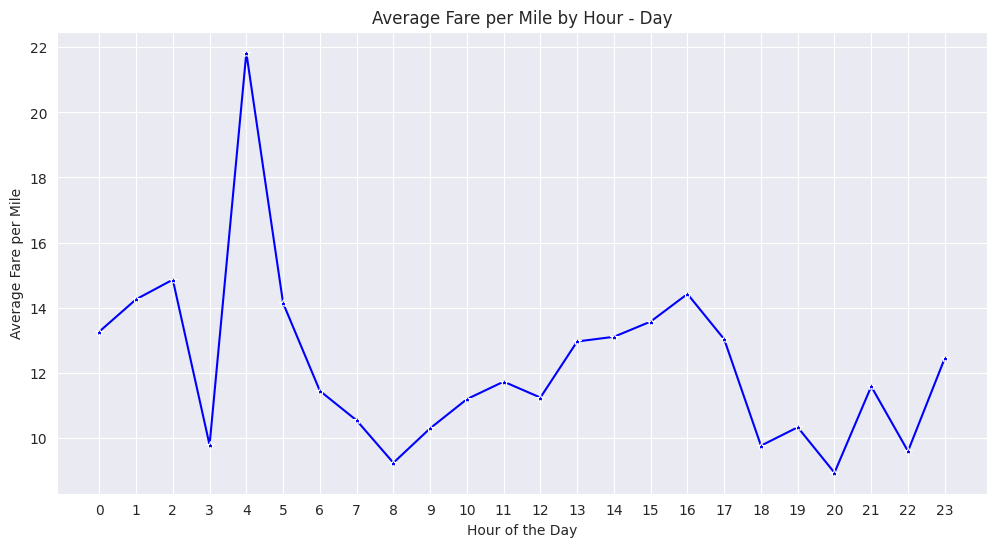

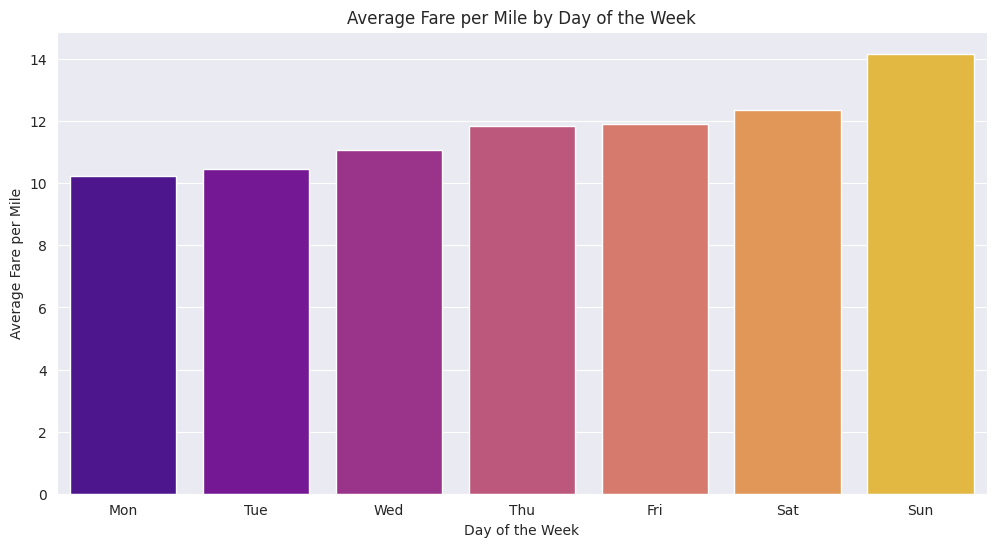

In [381]:
# Compare the average fare per mile for different days and for different times of the day
 #Group by hour of the day and calculate average fare per mile
avg_fare_by_hour = taxi_data_zones_merged.groupby('pickup_hour')['fare_per_mile'].mean()

# Group by day of the week and calculate average fare per mile
avg_fare_by_day = taxi_data_zones_merged.groupby('pickup_day')['fare_per_mile'].mean()

# Plot the average fare per mile by hour of day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_fare_by_hour.index, y=avg_fare_by_hour.values, marker='*', color='blue')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Fare per Mile")
plt.title("Average Fare per Mile by Hour - Day")
plt.xticks(range(0, 24), labels=[f"{i}" for i in range(0, 24)])
plt.show()

# Plot the average fare per mile by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_fare_by_day.index, y=avg_fare_by_day.values, palette="plasma")
plt.xlabel("Day of the Week")
plt.ylabel("Average Fare per Mile")
plt.title("Average Fare per Mile by Day of the Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

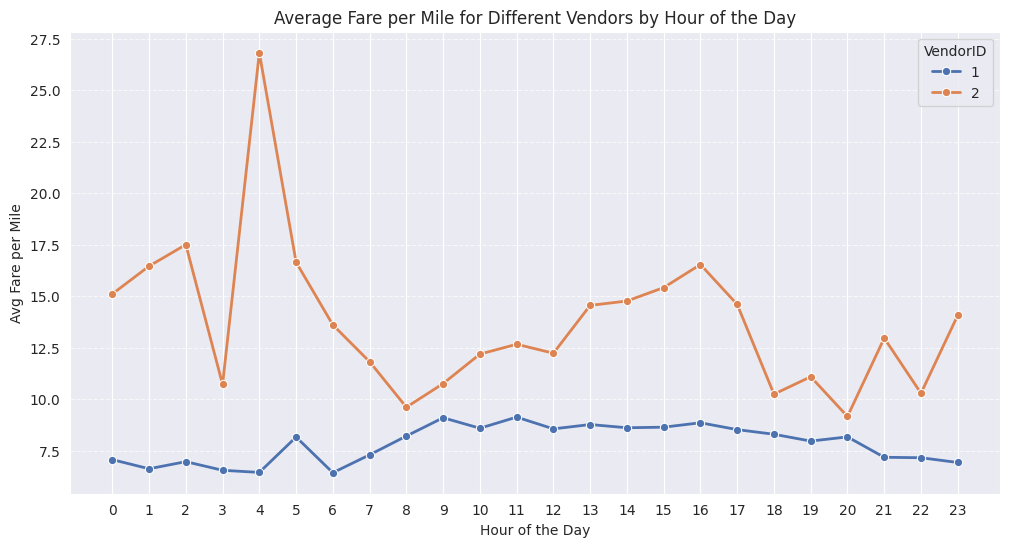

In [382]:
# Compare fare per mile for different vendors

fare_by_vendor_hour = taxi_data_zones_merged.groupby(["VendorID", "pickup_hour"])["fare_per_mile"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    x="pickup_hour", y="fare_per_mile", hue="VendorID", data=fare_by_vendor_hour,
    marker="o", palette="deep", linewidth=2, ci=95  # Adding confidence interval
)

# Formatting
plt.xlabel("Hour of the Day")
plt.ylabel("Avg Fare per Mile")
plt.title("Average Fare per Mile for Different Vendors by Hour of the Day")
plt.xticks(range(0, 24))
plt.legend(title="VendorID")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Dotted gridlines for better readability

plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


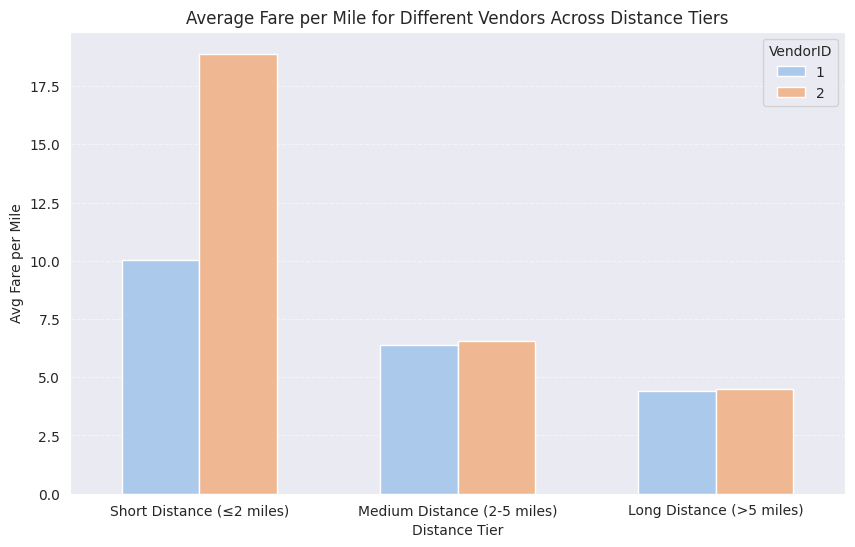

In [383]:
# Defining distance tiers
def categorize_distance(distance):
    if distance <= 2:
        return "Short Distance (≤2 miles)"
    elif 2 < distance <= 5:
        return "Medium Distance (2-5 miles)"
    else:
        return "Long Distance (>5 miles)"

# Apply categorization
taxi_data_zones_merged["distance_tier"] = taxi_data_zones_merged["trip_distance"].apply(categorize_distance)

# Ensure correct categorical order
distance_order = ["Short Distance (≤2 miles)", "Medium Distance (2-5 miles)", "Long Distance (>5 miles)"]
taxi_data_zones_merged["distance_tier"] = pd.Categorical(taxi_data_zones_merged["distance_tier"], categories=distance_order, ordered=True)

# Group by VendorID & Distance Tier
fare_by_vendor_tier = taxi_data_zones_merged.groupby(["VendorID", "distance_tier"], as_index=False).agg(
    {"fare_per_mile": "mean"}
)

# Create grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="distance_tier", y="fare_per_mile", hue="VendorID", data=fare_by_vendor_tier, palette="pastel", dodge=True, width = .6)

# Formatting
plt.xlabel("Distance Tier")
plt.ylabel("Avg Fare per Mile")
plt.title("Average Fare per Mile for Different Vendors Across Distance Tiers")
plt.legend(title="VendorID")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()



##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [384]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
taxi_data_zones_merged['tip_percentage'] = (taxi_data_zones_merged['tip_amount'] / taxi_data_zones_merged['fare_amount']) * 100


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

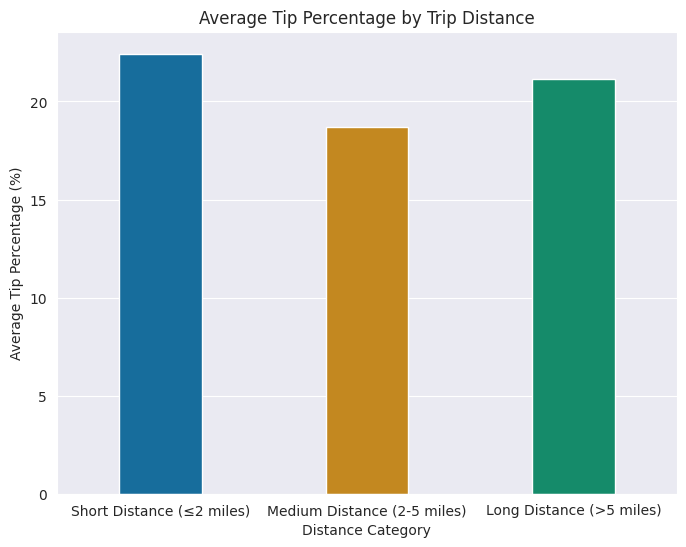

In [385]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Calculate the average tip percentage by distance category
avg_tip_by_distance = taxi_data_zones_merged.groupby('distance_tier')['tip_percentage'].mean().reset_index()


# Plot the average tip percentage by distance category
plt.figure(figsize=(8, 6))
sns.barplot(x="distance_tier", y="tip_percentage", data=avg_tip_by_distance, palette="colorblind", width = .4)
plt.xlabel('Distance Category')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip Percentage by Trip Distance')
plt.xticks(rotation=0)
plt.show()

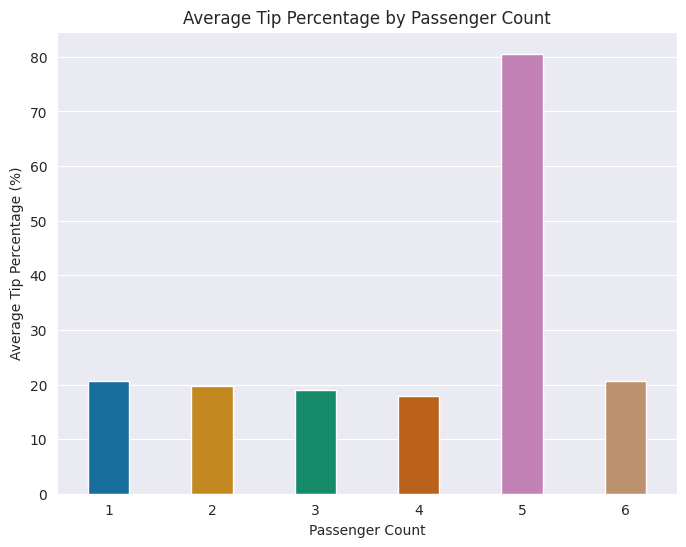

In [386]:
avg_tip_by_passenger_count = taxi_data_zones_merged.groupby('passenger_count')['tip_percentage'].mean().reset_index()

# Plot the average tip percentage by passenger count
plt.figure(figsize=(8, 6))
sns.barplot(x="passenger_count", y="tip_percentage", data=avg_tip_by_passenger_count, palette="colorblind", width = .4)
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip Percentage by Passenger Count')
plt.xticks(rotation=0)
plt.show()

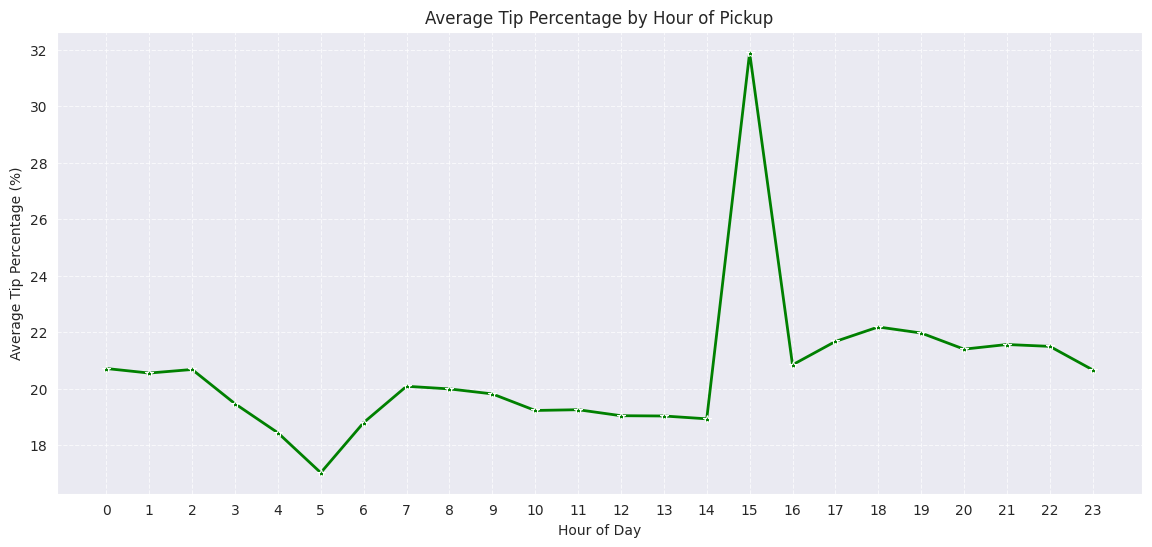

In [387]:
# Calculate the average tip percentage by hour of pickup
avg_tip_by_hour = taxi_data_zones_merged.groupby('pickup_hour')['tip_percentage'].mean().reset_index()

# Plot the average tip percentage by hour of the day
plt.figure(figsize=(14, 6))
sns.lineplot(data=avg_tip_by_hour, x="pickup_hour", y="tip_percentage", marker="*", color="green", linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Percentage (%)')
plt.title('Average Tip Percentage by Hour of Pickup')
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

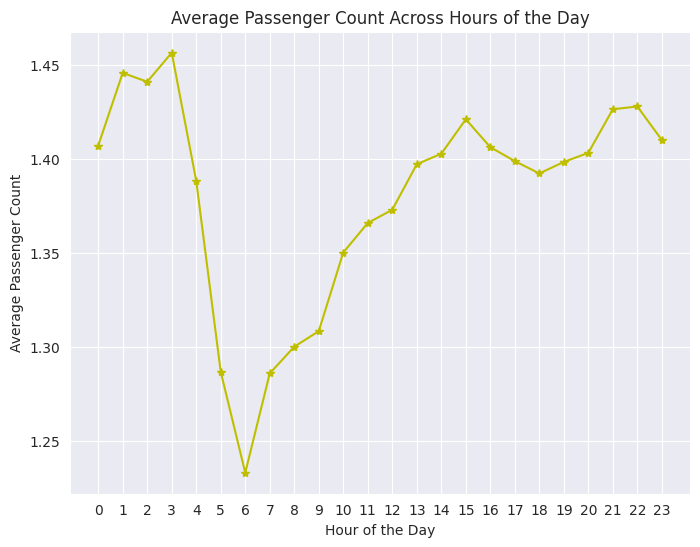

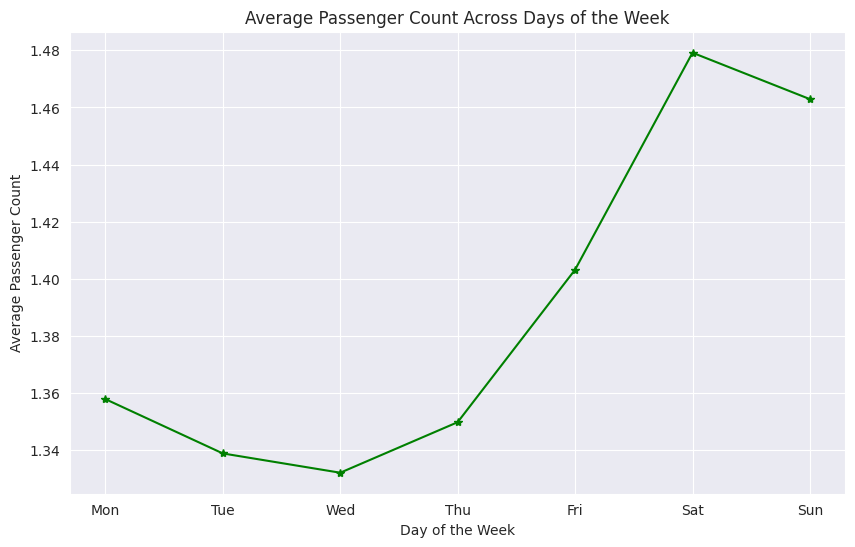

In [388]:
# See how passenger count varies across hours and days

# Group by hour of the day and calculate average passenger count
avg_passenger_by_hour = taxi_data_zones_merged.groupby('pickup_hour')['passenger_count'].mean()

# Group by day of the week and calculate average passenger count
avg_passenger_by_day = taxi_data_zones_merged.groupby('pickup_day')['passenger_count'].mean()

passenger_heatmap = taxi_data_zones_merged.groupby(['pickup_day', 'pickup_hour'])['passenger_count'].mean().unstack()

# Plot the variation of passenger count across hours of the day
plt.figure(figsize=(8, 6))
plt.plot(avg_passenger_by_hour.index, avg_passenger_by_hour.values, marker='*', color='y')
plt.title('Average Passenger Count Across Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')
plt.xticks(range(0, 24))  # Set x-ticks to represent hours of the day (0-23)
plt.grid(True)
plt.show()

# Plot the variation of passenger count across days of the week
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(10, 6))
plt.plot(avg_passenger_by_day.index, avg_passenger_by_day.values, marker='*', color='g')
plt.title('Average Passenger Count Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Passenger Count')
plt.xticks(range(0, 7), days_of_week)  # Set x-ticks to represent days of the week
plt.grid(True)
plt.show()


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

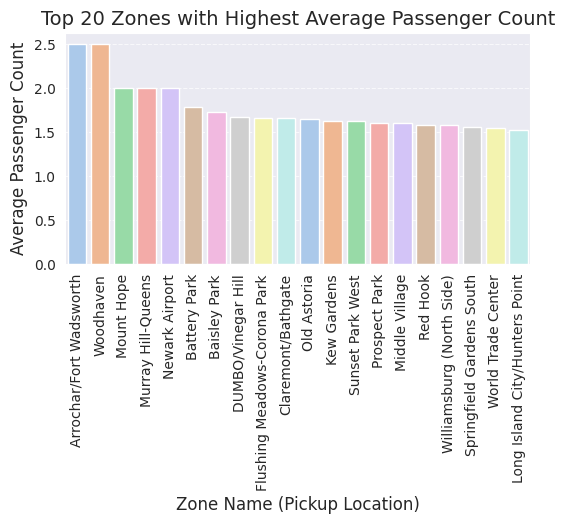

In [389]:
# How does passenger count vary across zones
# Group by 'zone' and calculate average passenger count
avg_passenger_by_zone = taxi_data_zones_merged.groupby('zone')['passenger_count'].mean()

# Sort in descending order for better visualization
avg_passenger_by_zone_sorted = avg_passenger_by_zone.sort_values(ascending=False).reset_index()

# **Plot top 20 zones with highest average passenger count**
plt.figure(figsize=(6, 3))
sns.barplot(x="zone", y="passenger_count", data=avg_passenger_by_zone_sorted.head(20), palette="pastel")

# Formatting
plt.title("Top 20 Zones with Highest Average Passenger Count", fontsize=14)
plt.xlabel("Zone Name (Pickup Location)", fontsize=12)
plt.ylabel("Average Passenger Count", fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()


In [390]:
taxi_data_zones_merged.columns.to_list()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee_new',
 'pickup_hour',
 'pickup_day',
 'pickup_month',
 'quarter',
 'trip_duration',
 'OBJECTID',
 'Shape_Leng',
 'Shape_Area',
 'zone',
 'LocationID',
 'borough',
 'geometry',
 'trip_duration_hours',
 'dropoff_hour',
 'fare_per_mile',
 'fare_per_mile_per_passenger',
 'distance_tier',
 'tip_percentage']

In [391]:
# Drop duplicate columns
taxi_data_zones_merged = taxi_data_zones_merged.drop(columns=['LocationID_dropoff', 'zone_dropoff'], errors='ignore')

# Verify that the columns are removed
print(taxi_data_zones_merged.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee_new', 'pickup_hour', 'pickup_day',
       'pickup_month', 'quarter', 'trip_duration', 'OBJECTID', 'Shape_Leng',
       'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry',
       'trip_duration_hours', 'dropoff_hour', 'fare_per_mile',
       'fare_per_mile_per_passenger', 'distance_tier', 'tip_percentage'],
      dtype='object')


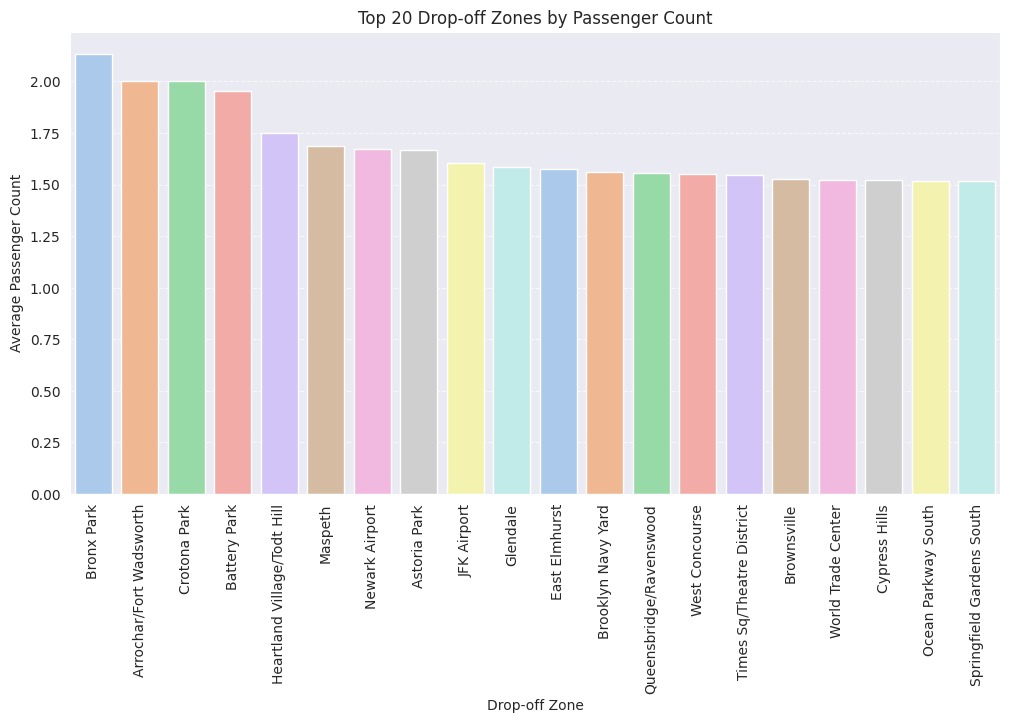

In [392]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Create a mapping of LocationID to Zone Name
location_to_zone = taxi_data_zones_merged[['LocationID', 'zone']].drop_duplicates()

# Merge drop-off location names into the dataset
taxi_data_zones_merged = taxi_data_zones_merged.merge(location_to_zone, left_on="DOLocationID", right_on="LocationID", how="left", suffixes=("", "_dropoff"))
# Group by Drop-off Zone Name instead of ID
avg_passenger_by_dropoff = taxi_data_zones_merged.groupby("zone_dropoff")["passenger_count"].mean().reset_index()

# Sort in descending order
avg_passenger_by_dropoff_sorted = avg_passenger_by_dropoff.sort_values(by="passenger_count", ascending=False)

# Plot top 20 drop-off zones
plt.figure(figsize=(12, 6))
sns.barplot(x="zone_dropoff", y="passenger_count", data=avg_passenger_by_dropoff_sorted.head(20), palette="pastel")
plt.xlabel("Drop-off Zone")
plt.ylabel("Average Passenger Count")
plt.title("Top 20 Drop-off Zones by Passenger Count")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

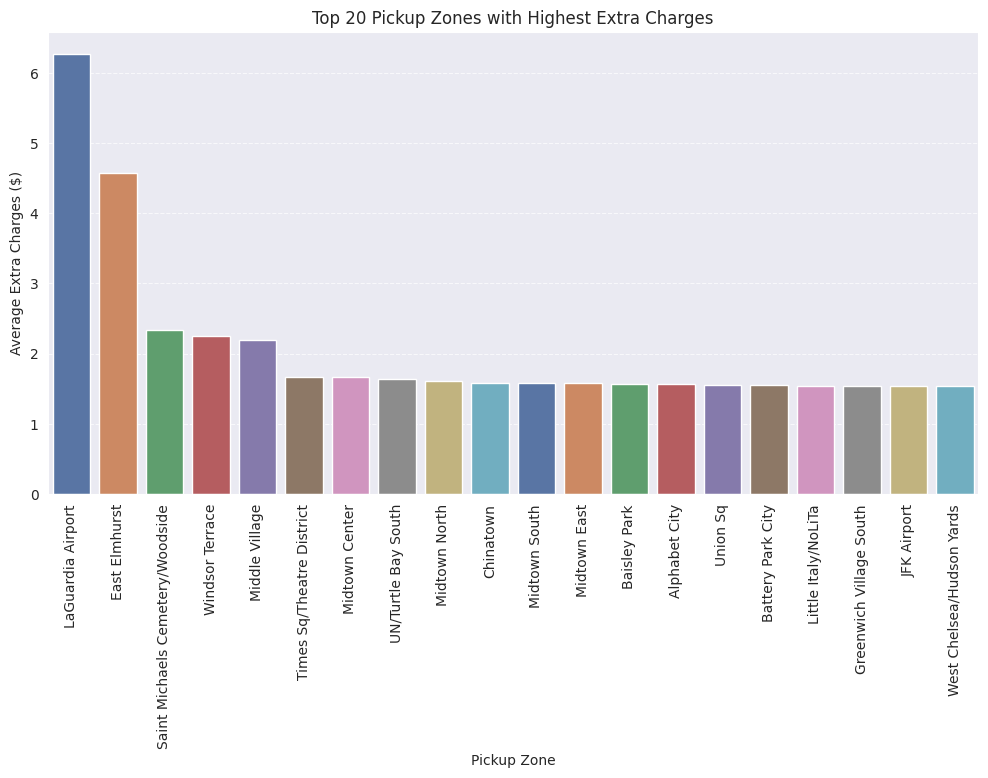

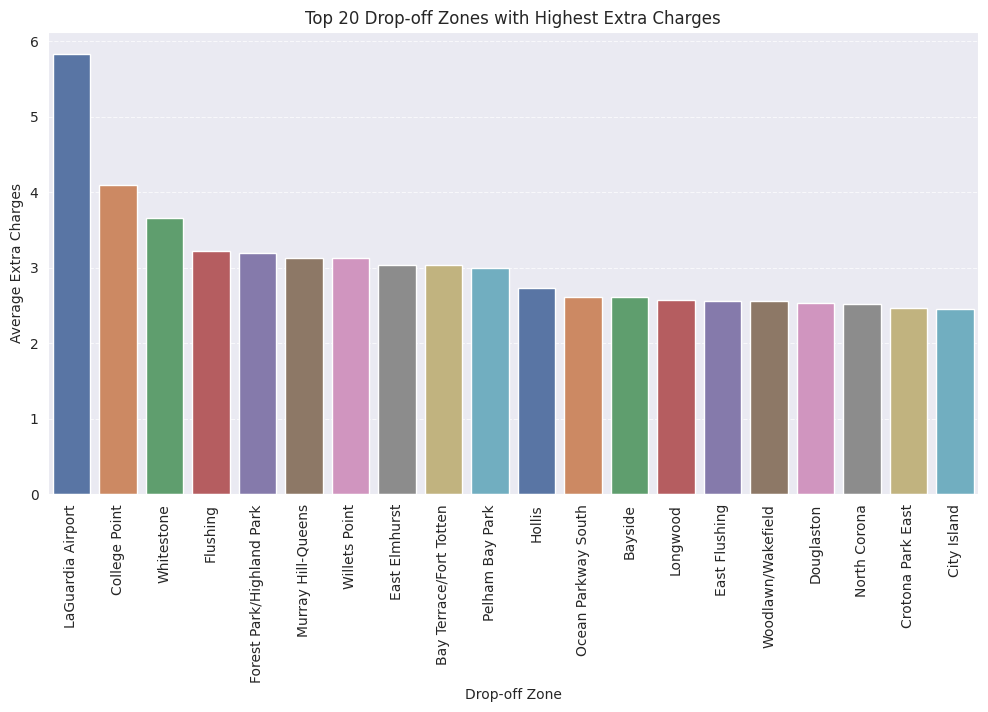

In [393]:
# How often is each surcharge applied?
# Calculate total extra charges per pickup zone
extra_by_pickup = taxi_data_zones_merged.groupby("zone")["extra"].mean().reset_index()

# Sort in descending order
extra_by_pickup_sorted = extra_by_pickup.sort_values(by="extra", ascending=False)

# Plot top 20 zones with highest extra charges
plt.figure(figsize=(12, 6))
sns.barplot(x="zone", y="extra", data=extra_by_pickup_sorted.head(20), palette="deep")
plt.xlabel("Pickup Zone")
plt.ylabel("Average Extra Charges ($)")
plt.title("Top 20 Pickup Zones with Highest Extra Charges")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Repeat for drop-off zones
extra_by_dropoff = taxi_data_zones_merged.groupby("zone_dropoff")["extra"].mean().reset_index()
extra_by_dropoff_sorted = extra_by_dropoff.sort_values(by="extra", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="zone_dropoff", y="extra", data=extra_by_dropoff_sorted.head(20), palette="deep")
plt.xlabel("Drop-off Zone")
plt.ylabel("Average Extra Charges")
plt.title("Top 20 Drop-off Zones with Highest Extra Charges")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



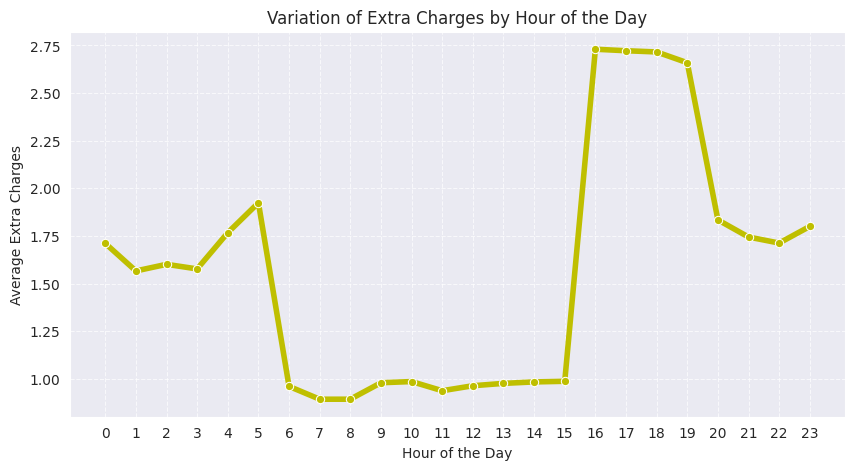

In [394]:
# Group by hour of the day and calculate average extra charges
extra_by_hour = taxi_data_zones_merged.groupby("pickup_hour")["extra"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=extra_by_hour, x="pickup_hour", y="extra", marker="o", color="y", linewidth=4)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Extra Charges")
plt.title("Variation of Extra Charges by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

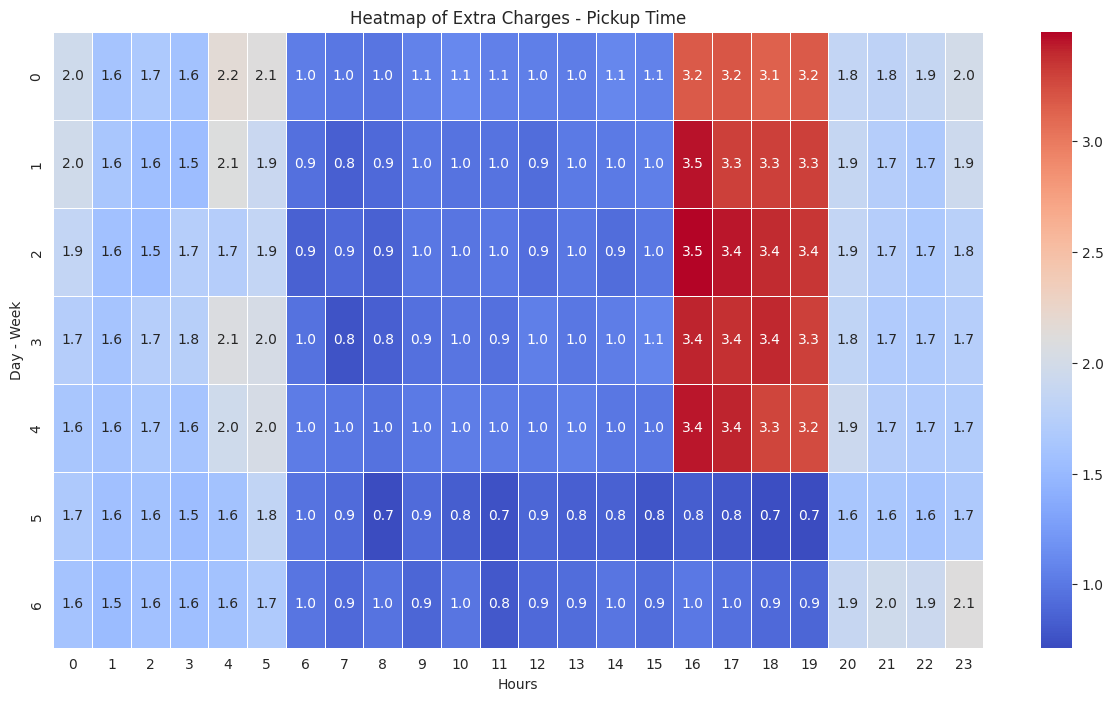

In [395]:
# Group by pickup day and hour to calculate average extra charges
extra_heatmap_data = taxi_data_zones_merged.groupby(["pickup_day", "pickup_hour"])["extra"].mean().unstack()

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(extra_heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Hours")
plt.ylabel("Day - Week")
plt.title("Heatmap of Extra Charges - Pickup Time")
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.